In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from os import path
from utils import plot_report

import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 20.0]
HDFStore=pd.HDFStore

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np

import config
import os
from scipy.signal import resample


In [2]:
# training parameters
seed= config.seed

dr=0.2
lr2=1e-3
lr1=1e-4
lr=8e-4

num_epochs=1000
mini_batch_size=53

main_units=64
secondary_units=16
last_unit=8
lstm_units=64
num_classes=3

#features=['x','y','pen_up','pressure']
features=['x','y']

doc_path = "/data/elekin/doc"
results_path = "/data/elekin/data/results/handwriting"

day="20220906"

print_sample=False

In [3]:
df = pd.read_csv(os.path.join(results_path,"biodarw_{}.csv".format(day))).set_index('subject_id')[features]
df.sample(5)

,x,y
subject_id,,
C104_2,6421,7368
T015,5879,7787
C08,5197,3373
C104_1,5110,3572
T023_2,5240,9310


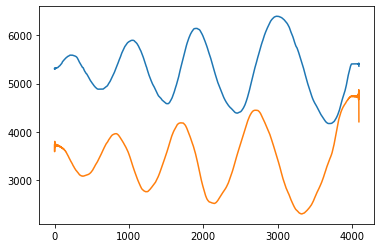

In [4]:
df_rs = df[features].groupby('subject_id').apply(resample, 4096)
_ = plt.plot(df_rs['C01_1'])

In [5]:
df_list = []
for feature in features:
    df_list.append(df[feature])

df_rs_1D = pd.concat(df_list).groupby('subject_id').apply(resample, len(features)*4096)
np.array(df_rs_1D.values.tolist()).shape

(53, 8192)

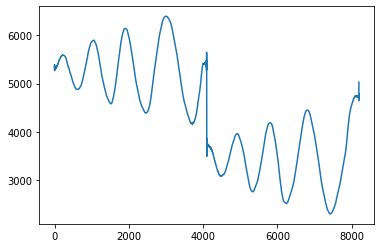

In [6]:
plt.plot(df_rs_1D['C01_1'])

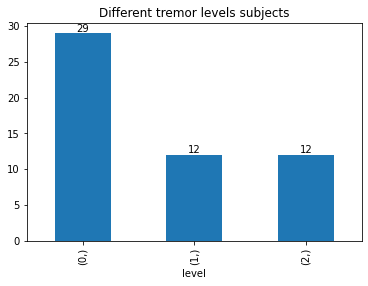

In [7]:
labels = pd.read_csv("/data/elekin/data/results/handwriting/level_20220903.csv", index_col=0).sort_index()
ax = labels.value_counts().plot.bar(title='Different tremor levels subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

In [8]:
np.array_equal(df_rs_1D.index.values, labels.index.values)

True

In [9]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(labels).astype(np.int16)
y.shape
#binary labels
#le = LabelEncoder().fit(labels.values.ravel())
#y = le.fit_transform(labels.values.ravel()).astype(np.int16)
#y

(53, 3)

In [10]:
X = np.array(df_rs_1D.values.tolist()).astype(np.float32)
X.shape

(53, 8192)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=38)

In [12]:
x_train.shape, x_test.shape

((35, 8192), (18, 8192))

In [13]:
num_features = x_train.shape[1]

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))

1 train batches and 1 test batches of 53 mini batch size and 0 steps per epoch


## FCNN ARCHITECTURE ANALISYS

Some training helpers functions

In [15]:
def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-5),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1000):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=1, shuffle=False)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [16]:
size_histories = {}

In [17]:
tiny = tf.keras.models.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)])

size_histories['fcnn/tiny'] = compile_and_fit(tiny, train_dataset, 
                                              test_dataset,
                                              "fcnn/tiny", 
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 524,547
Trainable params: 524,547
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 1s 673ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 2/1000
1/1 [==============================] - 0s 14ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 3/1000
1/1 [==============================] - 0s 10ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 4/1000
1/1

1/1 [==============================] - 0s 7ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 54/1000
1/1 [==============================] - 0s 7ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 55/1000
1/1 [==============================] - 0s 7ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 56/1000
1/1 [==============================] - 0s 6ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 57/1000
1/1 [==============================] - 0s 7ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 58/1000
1/1 [==============================] - 0s 6ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 59/1000
1/1 [==============================] - 0s 8ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 60/1000

1/1 [==============================] - 0s 6ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 111/1000
1/1 [==============================] - 0s 7ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 112/1000
1/1 [==============================] - 0s 6ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 113/1000
1/1 [==============================] - 0s 7ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 114/1000
1/1 [==============================] - 0s 6ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 115/1000
1/1 [==============================] - 0s 7ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 116/1000
1/1 [==============================] - 0s 6ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 1

Epoch 167/1000
1/1 [==============================] - 0s 7ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 168/1000
1/1 [==============================] - 0s 8ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 169/1000
1/1 [==============================] - 0s 6ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 170/1000
1/1 [==============================] - 0s 7ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 171/1000
1/1 [==============================] - 0s 6ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 172/1000
1/1 [==============================] - 0s 7ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy: 0.1111
Epoch 173/1000
1/1 [==============================] - 0s 6ms/step - loss: 11.5327 - accuracy: 0.2571 - val_loss: 14.3272 - val_accuracy:

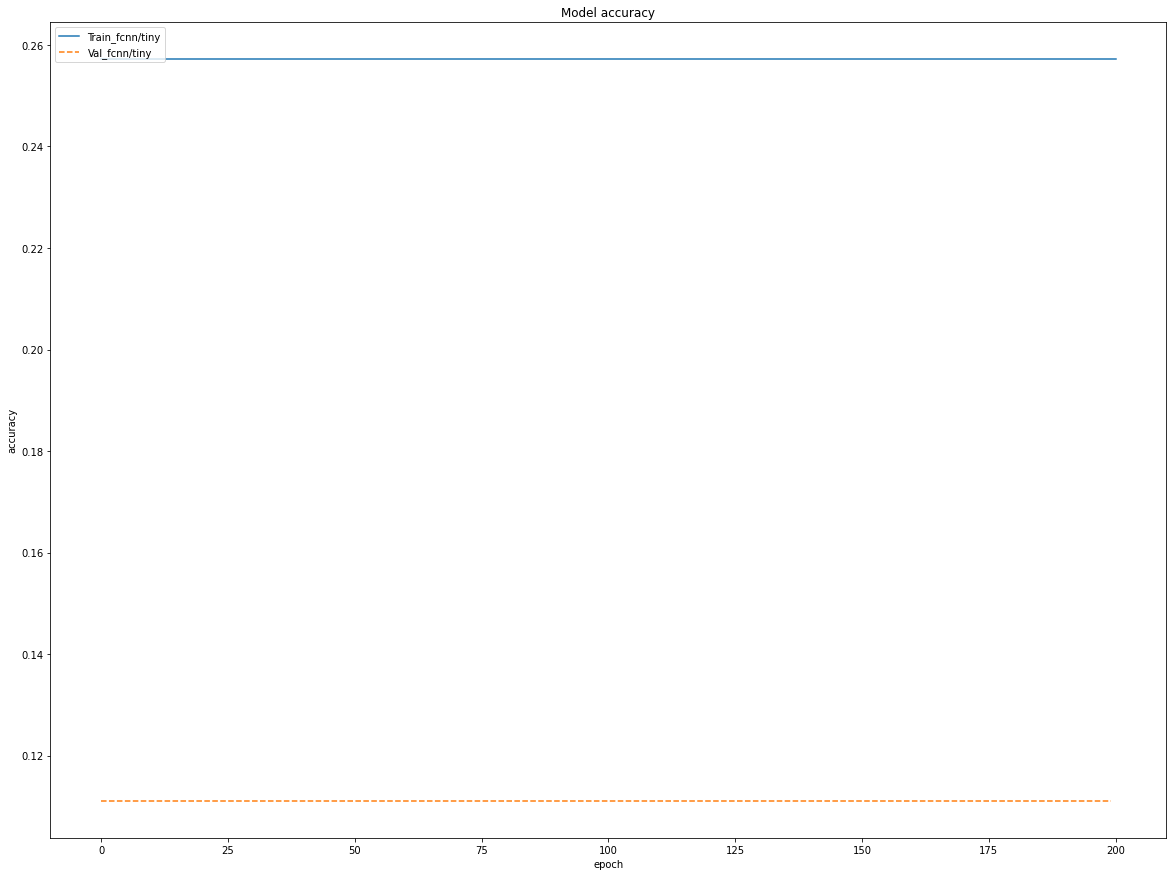

In [18]:
mpl.rcParams['figure.figsize'] = [20.0, 15.0]
plot_report(size_histories, metric='accuracy')

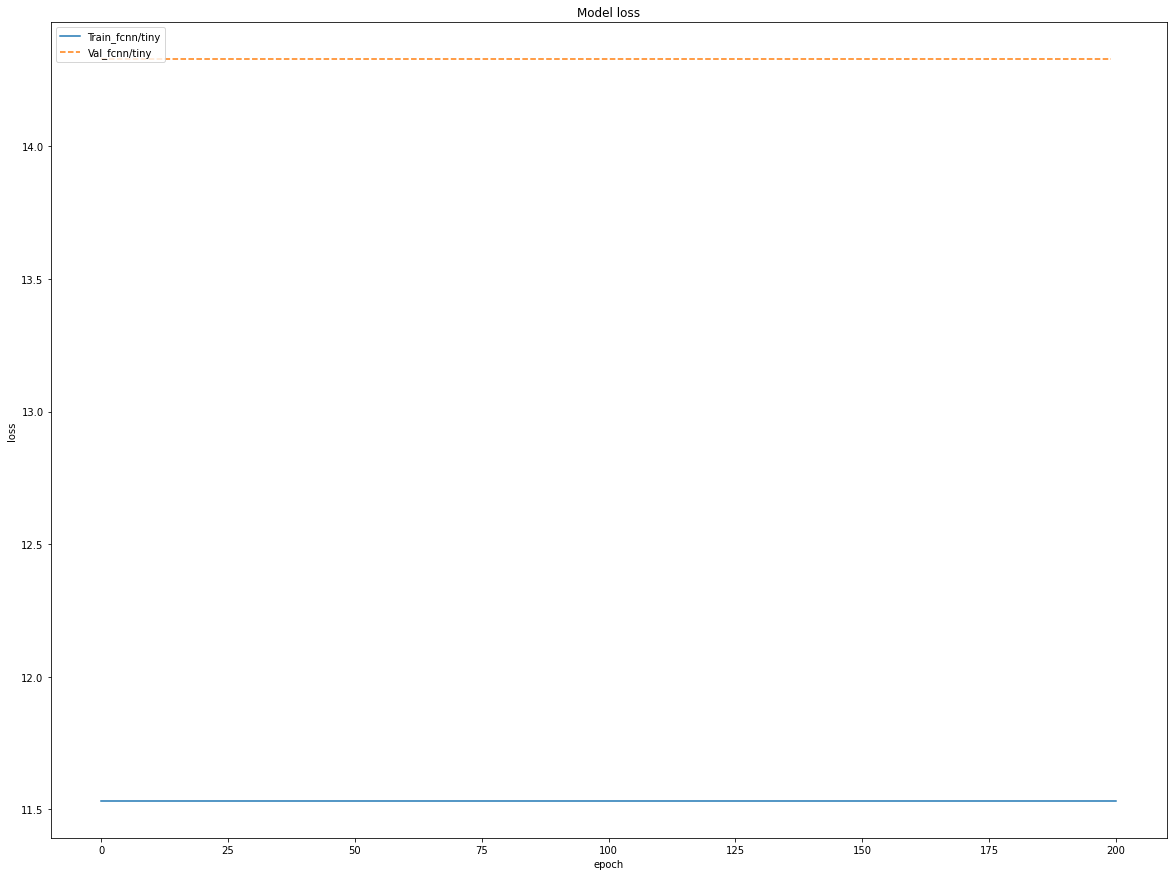

In [19]:
plot_report(size_histories, 'loss')

In [20]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/small'] = compile_and_fit(small_model, train_dataset, 
                                              test_dataset,'fcnn/small',
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/small'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/small'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 525,443
Trainable params: 525,443
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 0s 289ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 2/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 3/1000
1/1 [==============

1/1 [==============================] - 0s 8ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 54/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 55/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 56/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 57/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 58/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 59/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 60/1000
1/1 [========

1/1 [==============================] - 0s 6ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 112/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 113/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 114/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 115/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 116/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 117/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 118/1000
1/1 [=

Epoch 169/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 170/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 171/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 172/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 173/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 174/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 175/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2338 - accuracy: 0.5143 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 

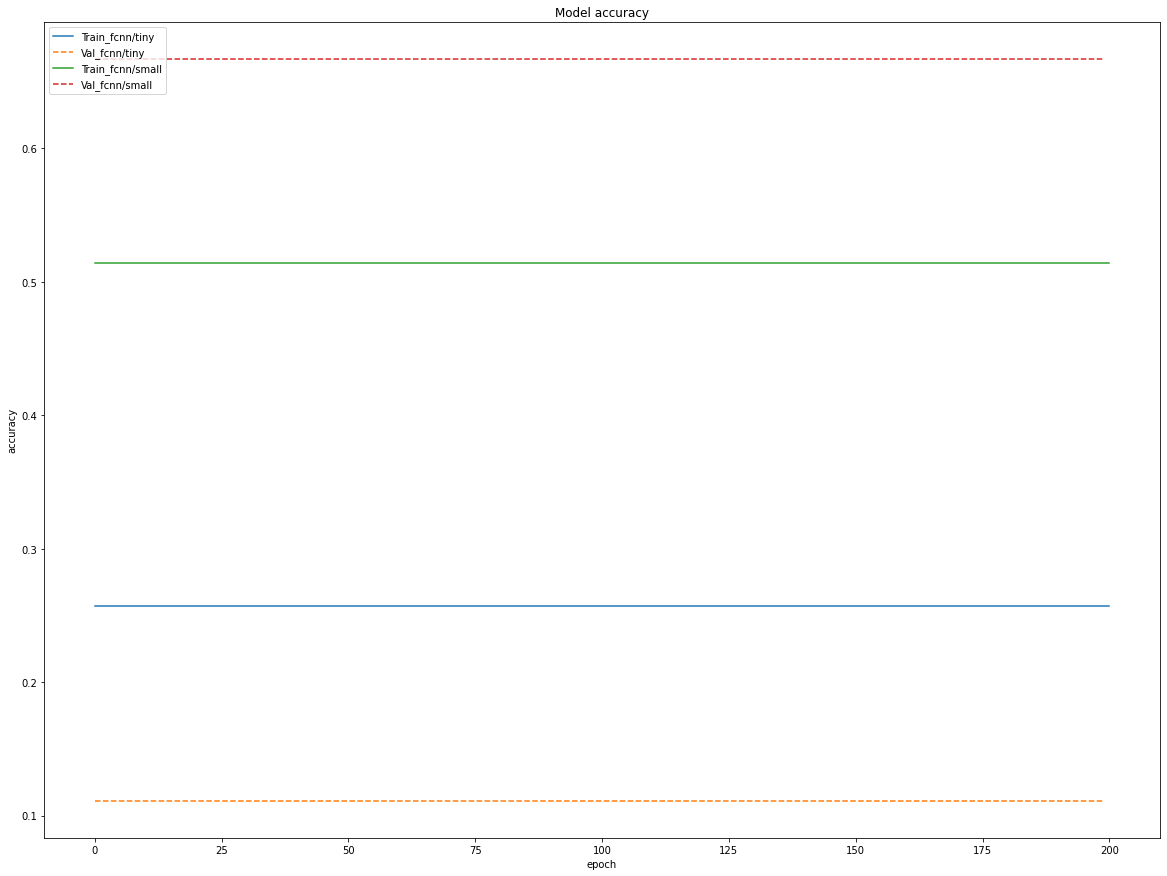

In [21]:
plot_report(size_histories)

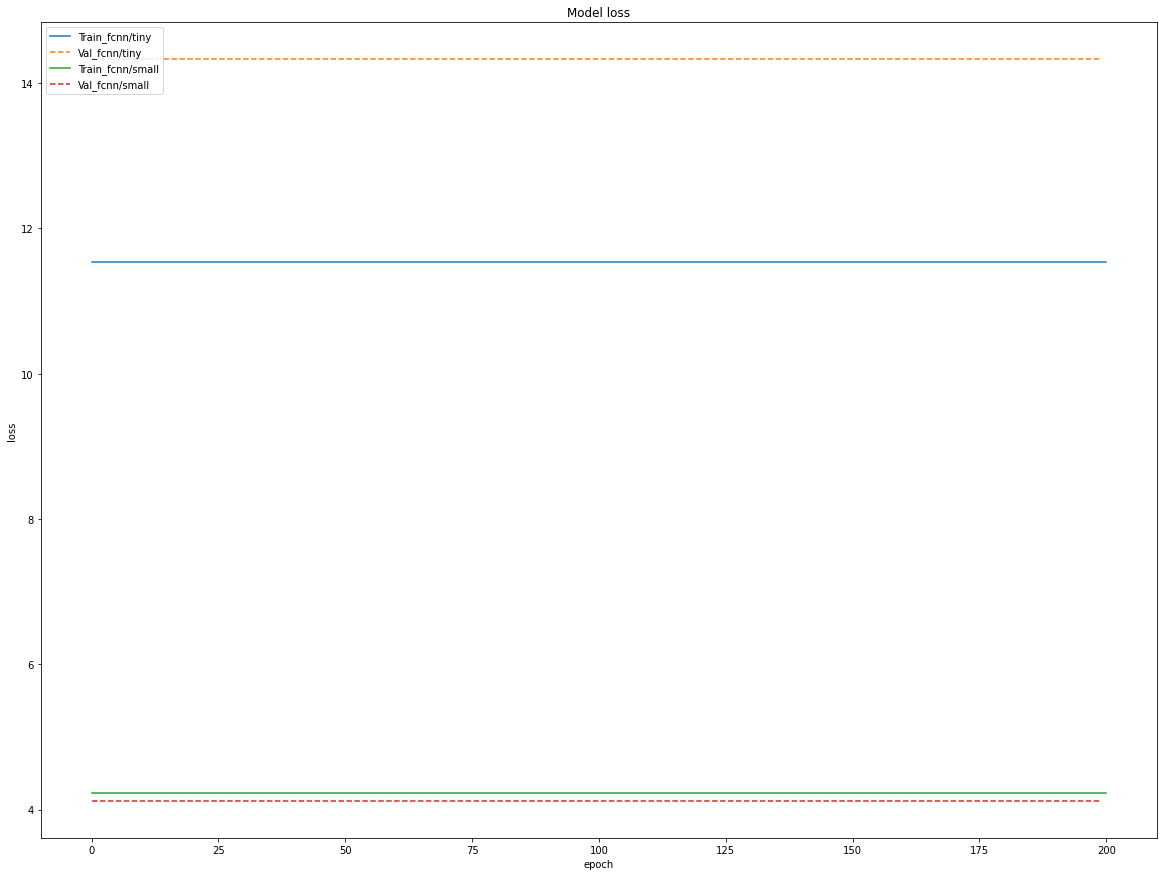

In [22]:
plot_report(size_histories, 'loss')

In [23]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),  
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/large'] = compile_and_fit(large_model, train_dataset, 
                                              test_dataset, "fcnn/large",
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer=get_optimizer(), 
                                              max_epochs=num_epochs)

print("Evaluation")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/large'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 3)                 27        
                                                                 
Total params: 529,715
Trainable params: 529,715
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 52/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 53/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 54/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 55/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 56/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 57/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 58/1000
1/1 [========

1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 110/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 111/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 112/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 113/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 114/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 115/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 116/1000
1/1 [=

Epoch 167/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 168/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 169/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 170/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 171/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 172/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 173/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2188 - accuracy: 0.4857 - val_loss: 4.1209 - val_accuracy: 0.6667
Epoch 

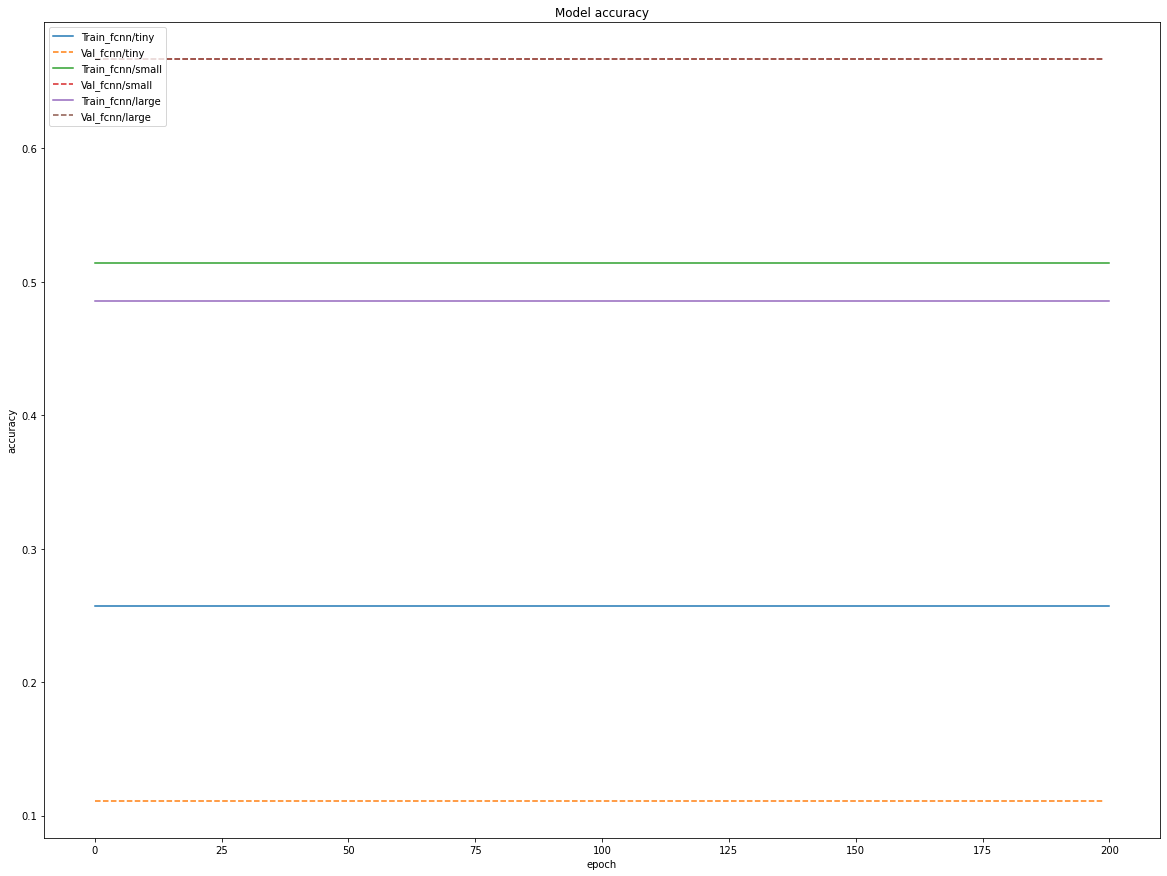

In [24]:
plot_report(size_histories)

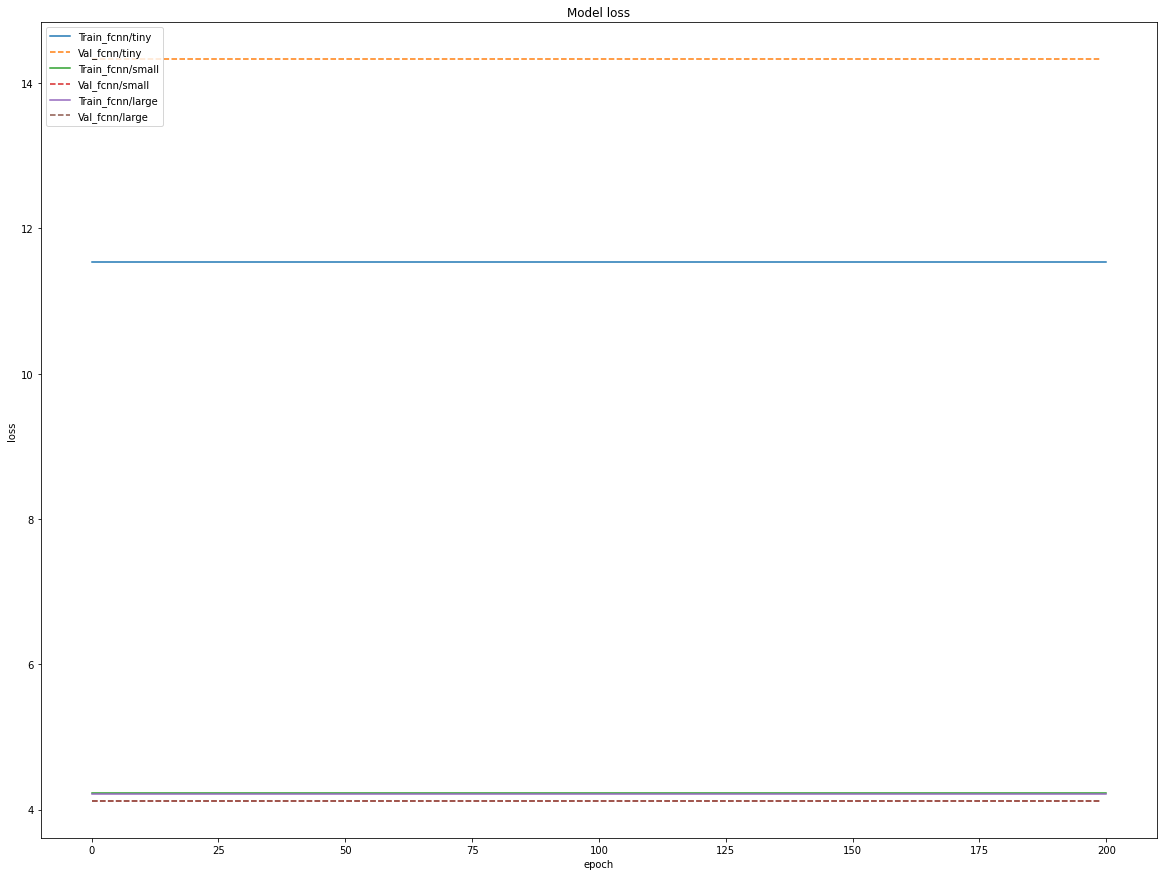

In [25]:
plot_report(size_histories, 'loss')

### Dropout

Although we got an accuracy of 0.75 looking at loss function chart is pretty obvious: There is overfiting. Now we have an overfitted NN let's make some adjustments to improve generalization capacity startin from dropout techniques.  

In [26]:
tiny_dropout = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/tiny/dropout'] = compile_and_fit(tiny_dropout, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/tiny/dropout", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATIO######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny/dropout'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny/dropout'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                524352    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 3)                 2

1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 52/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 53/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 54/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 55/1000
1/1 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 56/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 57/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 58/1000
1/1 [==============================] - 0s 7ms/step - lo

Epoch 112/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 113/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 114/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 115/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 116/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 117/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 118/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 119/1000
1/1 [============================

1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 173/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 174/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 175/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 176/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 177/1000
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 178/1000
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4857 - val_loss: nan - val_accuracy: 0.6667
Epoch 179/1000
1/1 [==============================] - 0s 7ms/st

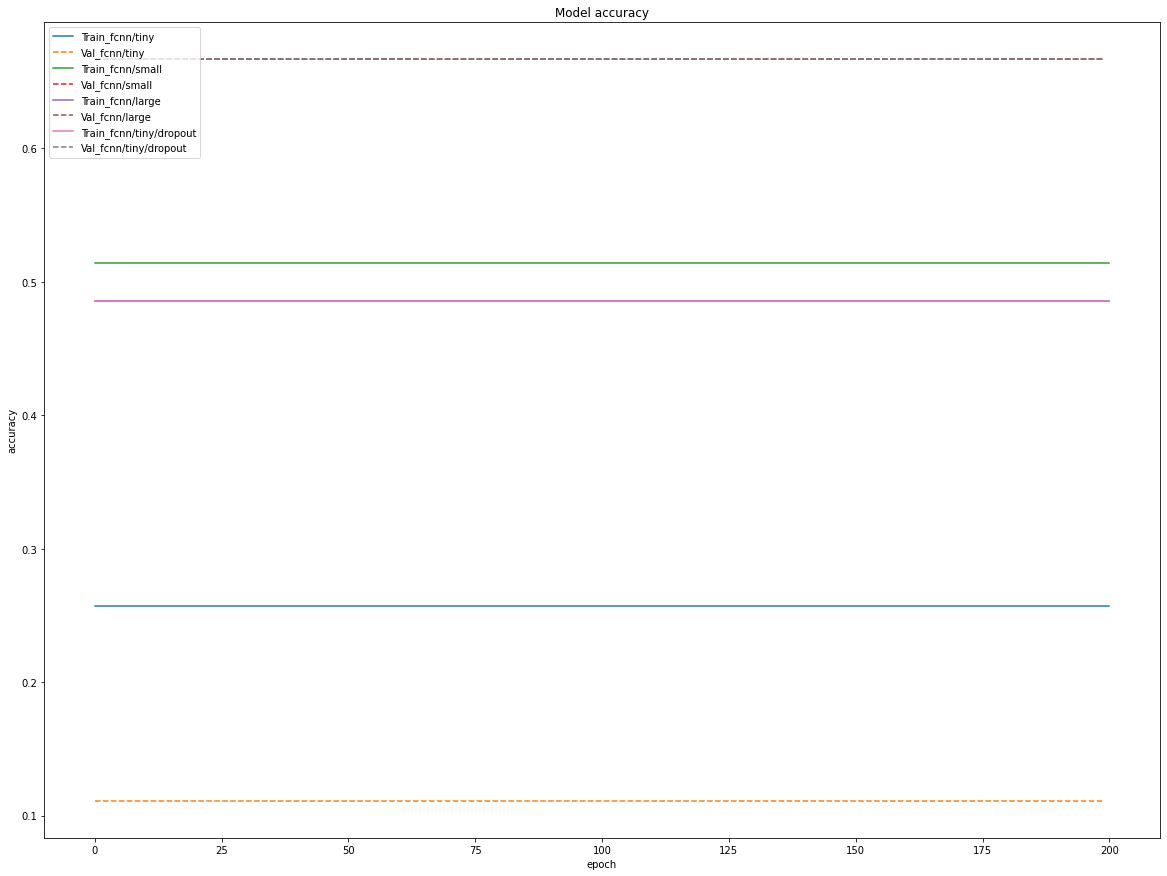

In [27]:
plot_report(size_histories)

Validation accuracy keeps improving more epoch with a total improvement from 0.75 to 0.81. Furthemore, the gap between training loss function and test loss function has been reduced.

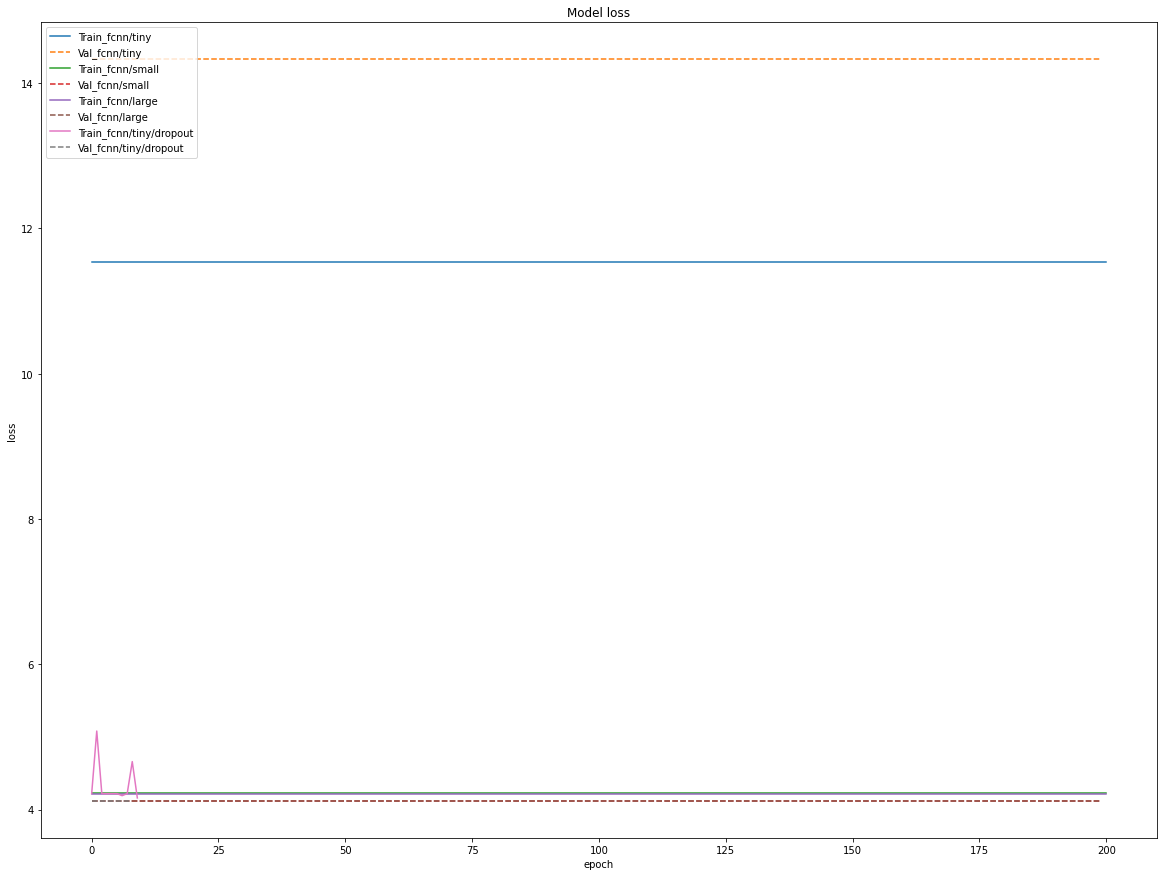

In [28]:
plot_report(size_histories, metric='loss')

### Kernel regularizer

In [29]:
# shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
# shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large']
regularizer_histories['dropout'] = size_histories['fcnn/tiny/dropout']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [30]:
l2_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
regularizer_histories['l2'] = compile_and_fit(l2_model, train_dataset, 
                                              test_dataset, 
                                              optimizer=tf.keras.optimizers.Adam(lr),
                                              name="regularizers/l2")
# Evaluate the model on the test data using `evaluate`
print("\n#######################EVALUATIO######################")
print('test acc:', max(regularizer_histories['l2'].history["val_accuracy"]))
print('train acc:', max(regularizer_histories['l2'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 3)                 27        
                                                                 
Total params: 529,715
Trainable params: 529,715
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] 

1/1 [==============================] - 0s 7ms/step - loss: 4.2779 - accuracy: 0.4857 - val_loss: 4.1794 - val_accuracy: 0.6667
Epoch 52/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2773 - accuracy: 0.4857 - val_loss: 4.1783 - val_accuracy: 0.6667
Epoch 53/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2762 - accuracy: 0.4857 - val_loss: 4.1768 - val_accuracy: 0.6667
Epoch 54/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2748 - accuracy: 0.4857 - val_loss: 4.1752 - val_accuracy: 0.6667
Epoch 55/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.2732 - accuracy: 0.4857 - val_loss: 4.1736 - val_accuracy: 0.6667
Epoch 56/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2716 - accuracy: 0.4857 - val_loss: 4.1724 - val_accuracy: 0.6667
Epoch 57/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2703 - accuracy: 0.4857 - val_loss: 4.1715 - val_accuracy: 0.6667
Epoch 58/1000
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 4.4150 - accuracy: 0.4857 - val_loss: 4.3168 - val_accuracy: 0.6667
Epoch 110/1000
1/1 [==============================] - 0s 9ms/step - loss: 4.4147 - accuracy: 0.4857 - val_loss: 4.3165 - val_accuracy: 0.6667
Epoch 111/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.4144 - accuracy: 0.4857 - val_loss: 4.3161 - val_accuracy: 0.6667
Epoch 112/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4141 - accuracy: 0.4857 - val_loss: 4.3158 - val_accuracy: 0.6667
Epoch 113/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.4137 - accuracy: 0.4857 - val_loss: 4.3155 - val_accuracy: 0.6667
Epoch 114/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4134 - accuracy: 0.4857 - val_loss: 4.3152 - val_accuracy: 0.6667
Epoch 115/1000
1/1 [==============================] - 0s 9ms/step - loss: 4.4131 - accuracy: 0.4857 - val_loss: 4.3149 - val_accuracy: 0.6667
Epoch 116/1000
1/1 [

Epoch 167/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.3999 - accuracy: 0.4857 - val_loss: 4.3017 - val_accuracy: 0.6667
Epoch 168/1000
1/1 [==============================] - 0s 9ms/step - loss: 4.3996 - accuracy: 0.4857 - val_loss: 4.3015 - val_accuracy: 0.6667
Epoch 169/1000
1/1 [==============================] - 0s 9ms/step - loss: 4.3995 - accuracy: 0.4857 - val_loss: 4.3013 - val_accuracy: 0.6667
Epoch 170/1000
1/1 [==============================] - 0s 10ms/step - loss: 4.3992 - accuracy: 0.4857 - val_loss: 4.3011 - val_accuracy: 0.6667
Epoch 171/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.3990 - accuracy: 0.4857 - val_loss: 4.3009 - val_accuracy: 0.6667
Epoch 172/1000
1/1 [==============================] - 0s 9ms/step - loss: 4.3988 - accuracy: 0.4857 - val_loss: 4.3007 - val_accuracy: 0.6667
Epoch 173/1000
1/1 [==============================] - 0s 9ms/step - loss: 4.3986 - accuracy: 0.4857 - val_loss: 4.3005 - val_accuracy: 0.6667
Epoch

Epoch 225/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.3899 - accuracy: 0.4857 - val_loss: 4.2918 - val_accuracy: 0.6667
Epoch 226/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.3898 - accuracy: 0.4857 - val_loss: 4.2917 - val_accuracy: 0.6667
Epoch 227/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.3896 - accuracy: 0.4857 - val_loss: 4.2916 - val_accuracy: 0.6667
Epoch 228/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.3895 - accuracy: 0.4857 - val_loss: 4.2915 - val_accuracy: 0.6667
Epoch 229/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.3894 - accuracy: 0.4857 - val_loss: 4.2913 - val_accuracy: 0.6667
Epoch 230/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.3893 - accuracy: 0.4857 - val_loss: 4.2912 - val_accuracy: 0.6667
Epoch 231/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.3891 - accuracy: 0.4857 - val_loss: 4.2911 - val_accuracy: 0.6667
Epoch 

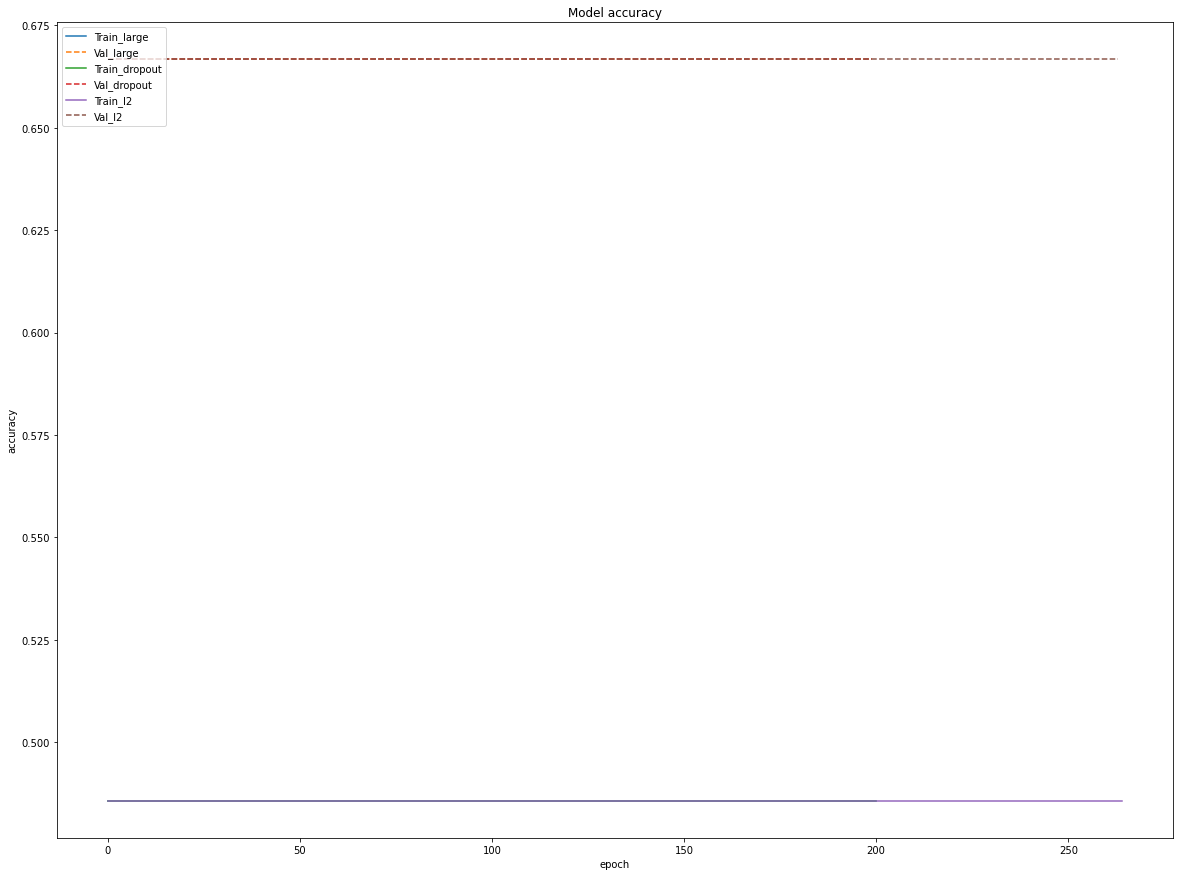

In [31]:
plot_report(regularizer_histories, 'accuracy')

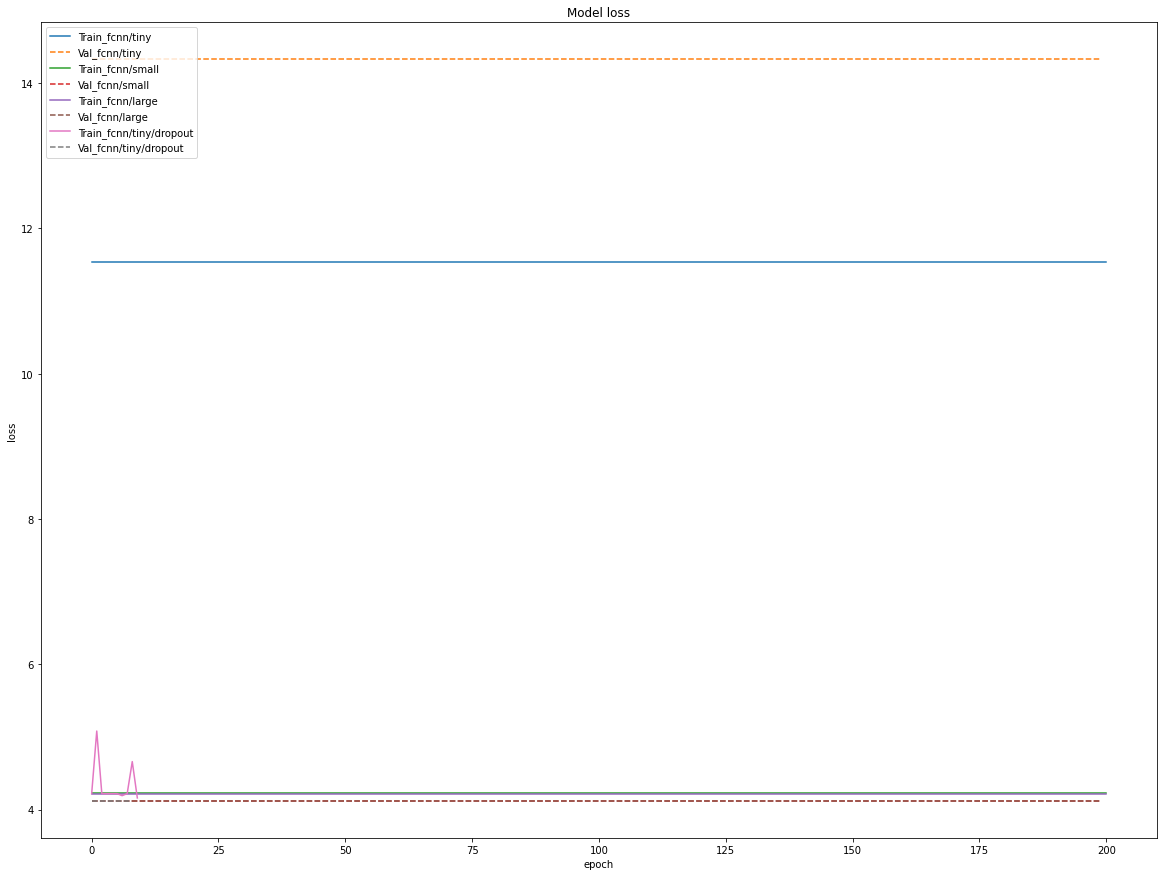

In [32]:
plot_report(size_histories, 'loss')

Now let's see what happens combining both techniques

In [33]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
combined_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    tf.keras.layers.Dropout(dr),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])

tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
regularizer_histories['combined'] = compile_and_fit(combined_model, train_dataset, test_dataset, "regularizers/combined",
                                                   optimizer=get_optimizer())

# Evaluate the model on the test data using `evaluate`
print()
print('test acc:', max(regularizer_histories['combined'].history["val_accuracy"]))
print('train acc:', max(regularizer_histories['combined'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 3)                 27        
                                                                 
Total params: 529,715
Trainable params: 529,715
Non-trai

1/1 [==============================] - 0s 7ms/step - loss: 4.8072 - accuracy: 0.4857 - val_loss: 4.6954 - val_accuracy: 0.6667
Epoch 51/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.3642 - accuracy: 0.4857 - val_loss: 4.6930 - val_accuracy: 0.6667
Epoch 52/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.7910 - accuracy: 0.4857 - val_loss: 4.6907 - val_accuracy: 0.6667
Epoch 53/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.8002 - accuracy: 0.4857 - val_loss: 4.6884 - val_accuracy: 0.6667
Epoch 54/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.8095 - accuracy: 0.4857 - val_loss: 4.6862 - val_accuracy: 0.6667
Epoch 55/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.7957 - accuracy: 0.4857 - val_loss: 4.6839 - val_accuracy: 0.6667
Epoch 56/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.7818 - accuracy: 0.4857 - val_loss: 4.6816 - val_accuracy: 0.6667
Epoch 57/1000
1/1 [========

1/1 [==============================] - 0s 7ms/step - loss: 4.6784 - accuracy: 0.4857 - val_loss: 4.5788 - val_accuracy: 0.6667
Epoch 109/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.6767 - accuracy: 0.4857 - val_loss: 4.5771 - val_accuracy: 0.6667
Epoch 110/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.6750 - accuracy: 0.4857 - val_loss: 4.5754 - val_accuracy: 0.6667
Epoch 111/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.6965 - accuracy: 0.4857 - val_loss: 4.5737 - val_accuracy: 0.6667
Epoch 112/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.6717 - accuracy: 0.4857 - val_loss: 4.5721 - val_accuracy: 0.6667
Epoch 113/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.6700 - accuracy: 0.4857 - val_loss: 4.5704 - val_accuracy: 0.6667
Epoch 114/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.6683 - accuracy: 0.4857 - val_loss: 4.5688 - val_accuracy: 0.6667
Epoch 115/1000
1/1 [=

Epoch 166/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5957 - accuracy: 0.4857 - val_loss: 4.4967 - val_accuracy: 0.6667
Epoch 167/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5946 - accuracy: 0.4857 - val_loss: 4.4955 - val_accuracy: 0.6667
Epoch 168/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5934 - accuracy: 0.4857 - val_loss: 4.4944 - val_accuracy: 0.6667
Epoch 169/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.5923 - accuracy: 0.4857 - val_loss: 4.4933 - val_accuracy: 0.6667
Epoch 170/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.1621 - accuracy: 0.4857 - val_loss: 4.4921 - val_accuracy: 0.6667
Epoch 171/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5901 - accuracy: 0.4857 - val_loss: 4.4910 - val_accuracy: 0.6667
Epoch 172/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5890 - accuracy: 0.4857 - val_loss: 4.4899 - val_accuracy: 0.6667
Epoch 

Epoch 224/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5547 - accuracy: 0.4857 - val_loss: 4.4445 - val_accuracy: 0.6667
Epoch 225/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5425 - accuracy: 0.4857 - val_loss: 4.4439 - val_accuracy: 0.6667
Epoch 226/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.5418 - accuracy: 0.4857 - val_loss: 4.4432 - val_accuracy: 0.6667
Epoch 227/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.5412 - accuracy: 0.4857 - val_loss: 4.4426 - val_accuracy: 0.6667
Epoch 228/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.5405 - accuracy: 0.4857 - val_loss: 4.4420 - val_accuracy: 0.6667
Epoch 229/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5399 - accuracy: 0.4857 - val_loss: 4.4413 - val_accuracy: 0.6667
Epoch 230/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.5393 - accuracy: 0.4857 - val_loss: 4.4407 - val_accuracy: 0.6667
Epoch 

Epoch 282/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.5167 - accuracy: 0.4857 - val_loss: 4.4185 - val_accuracy: 0.6667
Epoch 283/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5165 - accuracy: 0.4857 - val_loss: 4.4183 - val_accuracy: 0.6667
Epoch 284/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5279 - accuracy: 0.4857 - val_loss: 4.4181 - val_accuracy: 0.6667
Epoch 285/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5276 - accuracy: 0.4857 - val_loss: 4.4178 - val_accuracy: 0.6667
Epoch 286/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5158 - accuracy: 0.4857 - val_loss: 4.4176 - val_accuracy: 0.6667
Epoch 287/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.0865 - accuracy: 0.4857 - val_loss: 4.4174 - val_accuracy: 0.6667
Epoch 288/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5153 - accuracy: 0.4857 - val_loss: 4.4172 - val_accuracy: 0.6667
Epoch 

Epoch 340/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.5103 - accuracy: 0.4857 - val_loss: 4.4124 - val_accuracy: 0.6667
Epoch 341/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5103 - accuracy: 0.4857 - val_loss: 4.4123 - val_accuracy: 0.6667
Epoch 342/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5333 - accuracy: 0.4857 - val_loss: 4.4122 - val_accuracy: 0.6667
Epoch 343/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5216 - accuracy: 0.4857 - val_loss: 4.4122 - val_accuracy: 0.6667
Epoch 344/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.5101 - accuracy: 0.4857 - val_loss: 4.4121 - val_accuracy: 0.6667
Epoch 345/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5217 - accuracy: 0.4857 - val_loss: 4.4121 - val_accuracy: 0.6667
Epoch 346/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5329 - accuracy: 0.4857 - val_loss: 4.4120 - val_accuracy: 0.6667
Epoch 

Epoch 398/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5070 - accuracy: 0.4857 - val_loss: 4.4090 - val_accuracy: 0.6667
Epoch 399/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.0779 - accuracy: 0.4857 - val_loss: 4.4089 - val_accuracy: 0.6667
Epoch 400/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.5069 - accuracy: 0.4857 - val_loss: 4.4089 - val_accuracy: 0.6667
Epoch 401/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5068 - accuracy: 0.4857 - val_loss: 4.4088 - val_accuracy: 0.6667
Epoch 402/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5068 - accuracy: 0.4857 - val_loss: 4.4088 - val_accuracy: 0.6667
Epoch 403/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.5067 - accuracy: 0.4857 - val_loss: 4.4087 - val_accuracy: 0.6667
Epoch 404/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5067 - accuracy: 0.4857 - val_loss: 4.4087 - val_accuracy: 0.6667
Epoch 

1/1 [==============================] - 0s 8ms/step - loss: 4.5038 - accuracy: 0.4857 - val_loss: 4.4058 - val_accuracy: 0.6667
Epoch 456/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5037 - accuracy: 0.4857 - val_loss: 4.4057 - val_accuracy: 0.6667
Epoch 457/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5037 - accuracy: 0.4857 - val_loss: 4.4057 - val_accuracy: 0.6667
Epoch 458/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.0861 - accuracy: 0.4857 - val_loss: 4.4056 - val_accuracy: 0.6667
Epoch 459/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5036 - accuracy: 0.4857 - val_loss: 4.4056 - val_accuracy: 0.6667
Epoch 460/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5035 - accuracy: 0.4857 - val_loss: 4.4055 - val_accuracy: 0.6667
Epoch 461/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5034 - accuracy: 0.4857 - val_loss: 4.4055 - val_accuracy: 0.6667
Epoch 462/1000
1/1 [=

Epoch 513/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5006 - accuracy: 0.4857 - val_loss: 4.4026 - val_accuracy: 0.6667
Epoch 514/1000
1/1 [==============================] - 0s 9ms/step - loss: 4.5119 - accuracy: 0.4857 - val_loss: 4.4025 - val_accuracy: 0.6667
Epoch 515/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5005 - accuracy: 0.4857 - val_loss: 4.4025 - val_accuracy: 0.6667
Epoch 516/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.5004 - accuracy: 0.4857 - val_loss: 4.4024 - val_accuracy: 0.6667
Epoch 517/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5004 - accuracy: 0.4857 - val_loss: 4.4024 - val_accuracy: 0.6667
Epoch 518/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.5003 - accuracy: 0.4857 - val_loss: 4.4023 - val_accuracy: 0.6667
Epoch 519/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5002 - accuracy: 0.4857 - val_loss: 4.4022 - val_accuracy: 0.6667
Epoch 

Epoch 571/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4974 - accuracy: 0.4857 - val_loss: 4.3994 - val_accuracy: 0.6667
Epoch 572/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.4974 - accuracy: 0.4857 - val_loss: 4.3994 - val_accuracy: 0.6667
Epoch 573/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4973 - accuracy: 0.4857 - val_loss: 4.3993 - val_accuracy: 0.6667
Epoch 574/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4973 - accuracy: 0.4857 - val_loss: 4.3993 - val_accuracy: 0.6667
Epoch 575/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.0796 - accuracy: 0.4857 - val_loss: 4.3992 - val_accuracy: 0.6667
Epoch 576/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4972 - accuracy: 0.4857 - val_loss: 4.3992 - val_accuracy: 0.6667
Epoch 577/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.4971 - accuracy: 0.4857 - val_loss: 4.3991 - val_accuracy: 0.6667
Epoch 

Epoch 629/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4943 - accuracy: 0.4857 - val_loss: 4.3963 - val_accuracy: 0.6667
Epoch 630/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4943 - accuracy: 0.4857 - val_loss: 4.3963 - val_accuracy: 0.6667
Epoch 631/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.4942 - accuracy: 0.4857 - val_loss: 4.3962 - val_accuracy: 0.6667
Epoch 632/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4942 - accuracy: 0.4857 - val_loss: 4.3962 - val_accuracy: 0.6667
Epoch 633/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4941 - accuracy: 0.4857 - val_loss: 4.3961 - val_accuracy: 0.6667
Epoch 634/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5055 - accuracy: 0.4857 - val_loss: 4.3961 - val_accuracy: 0.6667
Epoch 635/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.4940 - accuracy: 0.4857 - val_loss: 4.3960 - val_accuracy: 0.6667
Epoch 

Epoch 687/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4913 - accuracy: 0.4857 - val_loss: 4.3933 - val_accuracy: 0.6667
Epoch 688/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.4913 - accuracy: 0.4857 - val_loss: 4.3933 - val_accuracy: 0.6667
Epoch 689/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4912 - accuracy: 0.4857 - val_loss: 4.3932 - val_accuracy: 0.6667
Epoch 690/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.9319 - accuracy: 0.4857 - val_loss: 4.3932 - val_accuracy: 0.6667
Epoch 691/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4911 - accuracy: 0.4857 - val_loss: 4.3931 - val_accuracy: 0.6667
Epoch 692/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4911 - accuracy: 0.4857 - val_loss: 4.3931 - val_accuracy: 0.6667
Epoch 693/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.4910 - accuracy: 0.4857 - val_loss: 4.3930 - val_accuracy: 0.6667
Epoch 

Epoch 745/1000
1/1 [==============================] - 0s 6ms/step - loss: 4.4884 - accuracy: 0.4857 - val_loss: 4.3904 - val_accuracy: 0.6667
Epoch 746/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4884 - accuracy: 0.4857 - val_loss: 4.3904 - val_accuracy: 0.6667
Epoch 747/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4883 - accuracy: 0.4857 - val_loss: 4.3903 - val_accuracy: 0.6667
Epoch 748/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4883 - accuracy: 0.4857 - val_loss: 4.3903 - val_accuracy: 0.6667
Epoch 749/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.4882 - accuracy: 0.4857 - val_loss: 4.3902 - val_accuracy: 0.6667
Epoch 750/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4882 - accuracy: 0.4857 - val_loss: 4.3902 - val_accuracy: 0.6667
Epoch 751/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4881 - accuracy: 0.4857 - val_loss: 4.3901 - val_accuracy: 0.6667
Epoch 

Epoch 803/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.9263 - accuracy: 0.4857 - val_loss: 4.3876 - val_accuracy: 0.6667
Epoch 804/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4971 - accuracy: 0.4857 - val_loss: 4.3875 - val_accuracy: 0.6667
Epoch 805/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.4855 - accuracy: 0.4857 - val_loss: 4.3875 - val_accuracy: 0.6667
Epoch 806/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4854 - accuracy: 0.4857 - val_loss: 4.3874 - val_accuracy: 0.6667
Epoch 807/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4854 - accuracy: 0.4857 - val_loss: 4.3874 - val_accuracy: 0.6667
Epoch 808/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4853 - accuracy: 0.4857 - val_loss: 4.3873 - val_accuracy: 0.6667
Epoch 809/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.9260 - accuracy: 0.4857 - val_loss: 4.3873 - val_accuracy: 0.6667
Epoch 

Epoch 861/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4828 - accuracy: 0.4857 - val_loss: 4.3848 - val_accuracy: 0.6667
Epoch 862/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4827 - accuracy: 0.4857 - val_loss: 4.3848 - val_accuracy: 0.6667
Epoch 863/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.4827 - accuracy: 0.4857 - val_loss: 4.3847 - val_accuracy: 0.6667
Epoch 864/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4826 - accuracy: 0.4857 - val_loss: 4.3847 - val_accuracy: 0.6667
Epoch 865/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4826 - accuracy: 0.4857 - val_loss: 4.3846 - val_accuracy: 0.6667
Epoch 866/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4825 - accuracy: 0.4857 - val_loss: 4.3846 - val_accuracy: 0.6667
Epoch 867/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4825 - accuracy: 0.4857 - val_loss: 4.3845 - val_accuracy: 0.6667
Epoch 

Epoch 919/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4937 - accuracy: 0.4857 - val_loss: 4.3966 - val_accuracy: 0.6667
Epoch 920/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4945 - accuracy: 0.4857 - val_loss: 4.3973 - val_accuracy: 0.6667
Epoch 921/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.0663 - accuracy: 0.4857 - val_loss: 4.3980 - val_accuracy: 0.6667
Epoch 922/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.4959 - accuracy: 0.4857 - val_loss: 4.3986 - val_accuracy: 0.6667
Epoch 923/1000
1/1 [==============================] - 0s 9ms/step - loss: 4.4767 - accuracy: 0.4857 - val_loss: 4.3991 - val_accuracy: 0.6667
Epoch 924/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4773 - accuracy: 0.4857 - val_loss: 4.3996 - val_accuracy: 0.6667
Epoch 925/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4778 - accuracy: 0.4857 - val_loss: 4.4001 - val_accuracy: 0.6667
Epoch 

Epoch 977/1000
1/1 [==============================] - 0s 7ms/step - loss: 5.3933 - accuracy: 0.4857 - val_loss: 4.4023 - val_accuracy: 0.6667
Epoch 978/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.9409 - accuracy: 0.4857 - val_loss: 4.4023 - val_accuracy: 0.6667
Epoch 979/1000
1/1 [==============================] - 0s 7ms/step - loss: 5.3618 - accuracy: 0.4857 - val_loss: 4.4022 - val_accuracy: 0.6667
Epoch 980/1000
1/1 [==============================] - 0s 8ms/step - loss: 4.5002 - accuracy: 0.4857 - val_loss: 4.4022 - val_accuracy: 0.6667
Epoch 981/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.4803 - accuracy: 0.4857 - val_loss: 4.4021 - val_accuracy: 0.6667
Epoch 982/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.5114 - accuracy: 0.4857 - val_loss: 4.4021 - val_accuracy: 0.6667
Epoch 983/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.9210 - accuracy: 0.4857 - val_loss: 4.4021 - val_accuracy: 0.6667
Epoch 

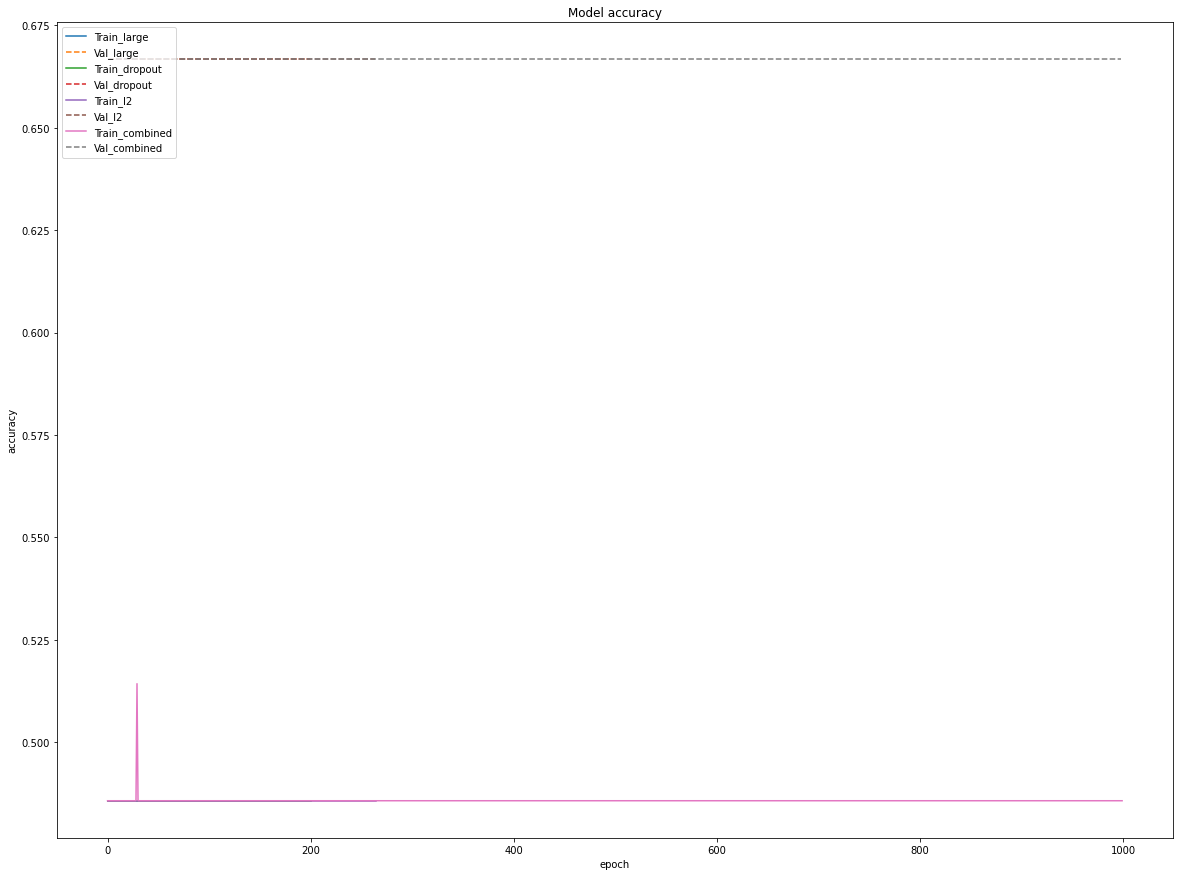

In [34]:
plot_report(regularizer_histories, 'accuracy')

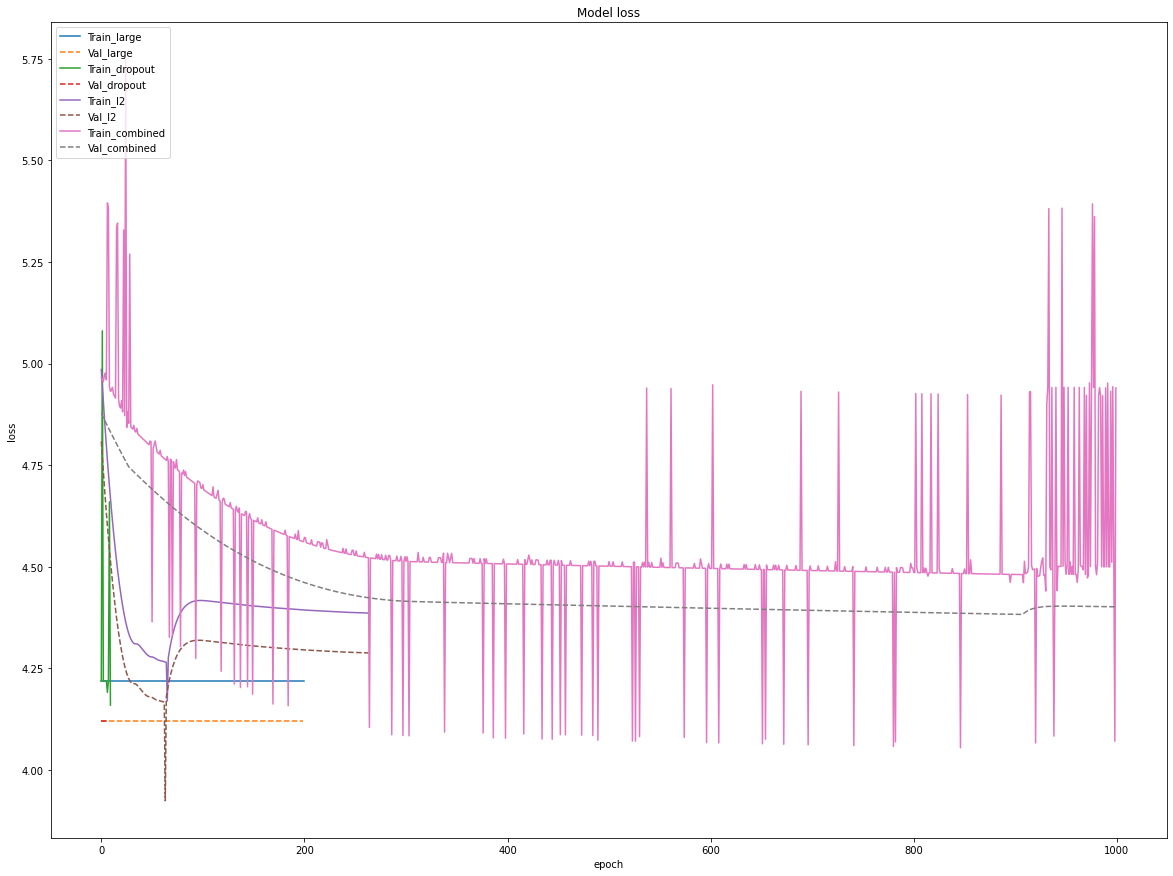

In [35]:
plot_report(regularizer_histories, 'loss')

## Batch Normalization

Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. It was proposed by Sergey Ioffe and Christian Szegedy in 2015.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Tensorflow implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)


In [36]:
batch_histories = {}
batch_histories['large'] = size_histories['fcnn/large']
batch_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [37]:
small_batch = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
batch_histories['fcnn/small/batch'] = compile_and_fit(small_batch, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/small/batch", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(batch_histories['fcnn/small/batch'].history["accuracy"]))
print('test acc:', max(batch_histories['fcnn/small/batch'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                524352    
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 batch_normalization_2 (Batc  (None, 16)               6

Epoch 45/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6633 - accuracy: 0.7714 - val_loss: 1.2900 - val_accuracy: 0.6667
Epoch 46/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.6238 - accuracy: 0.8000 - val_loss: 1.2797 - val_accuracy: 0.6667
Epoch 47/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6525 - accuracy: 0.7714 - val_loss: 1.2759 - val_accuracy: 0.6667
Epoch 48/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6959 - accuracy: 0.7143 - val_loss: 1.2598 - val_accuracy: 0.6667
Epoch 49/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6646 - accuracy: 0.8286 - val_loss: 1.2385 - val_accuracy: 0.6667
Epoch 50/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6685 - accuracy: 0.8000 - val_loss: 1.2145 - val_accuracy: 0.6667
Epoch 51/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6352 - accuracy: 0.8000 - val_loss: 1.1914 - val_accuracy: 0.6667
Epoch 52/10

1/1 [==============================] - 0s 9ms/step - loss: 0.5314 - accuracy: 0.8286 - val_loss: 0.7916 - val_accuracy: 0.7222
Epoch 104/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.5253 - accuracy: 0.9143 - val_loss: 0.7927 - val_accuracy: 0.7222
Epoch 105/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5430 - accuracy: 0.8286 - val_loss: 0.7887 - val_accuracy: 0.7222
Epoch 106/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.5131 - accuracy: 0.8286 - val_loss: 0.7808 - val_accuracy: 0.5556
Epoch 107/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5276 - accuracy: 0.8571 - val_loss: 0.7772 - val_accuracy: 0.5556
Epoch 108/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.4993 - accuracy: 0.8857 - val_loss: 0.7758 - val_accuracy: 0.5000
Epoch 109/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.5201 - accuracy: 0.8286 - val_loss: 0.7740 - val_accuracy: 0.4444
Epoch 110/1000
1/1 [

Epoch 161/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4669 - accuracy: 0.8571 - val_loss: 0.7503 - val_accuracy: 0.6667
Epoch 162/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4525 - accuracy: 0.9143 - val_loss: 0.7411 - val_accuracy: 0.6667
Epoch 163/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.4399 - accuracy: 0.9429 - val_loss: 0.7284 - val_accuracy: 0.7778
Epoch 164/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4733 - accuracy: 0.8571 - val_loss: 0.7180 - val_accuracy: 0.7778
Epoch 165/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4461 - accuracy: 0.8571 - val_loss: 0.7074 - val_accuracy: 0.8889
Epoch 166/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4644 - accuracy: 0.9143 - val_loss: 0.6989 - val_accuracy: 0.8889
Epoch 167/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4751 - accuracy: 0.8857 - val_loss: 0.6856 - val_accuracy: 0.8889
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 0.4141 - accuracy: 0.8286 - val_loss: 0.6966 - val_accuracy: 0.6111
Epoch 219/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.4298 - accuracy: 0.8857 - val_loss: 0.6738 - val_accuracy: 0.6111
Epoch 220/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.4149 - accuracy: 0.9429 - val_loss: 0.6449 - val_accuracy: 0.7222
Epoch 221/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.4196 - accuracy: 0.9143 - val_loss: 0.6355 - val_accuracy: 0.7222
Epoch 222/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.3962 - accuracy: 0.9143 - val_loss: 0.6430 - val_accuracy: 0.7222
Epoch 223/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.4306 - accuracy: 0.9429 - val_loss: 0.6508 - val_accuracy: 0.7222
Epoch 224/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.3750 - accuracy: 0.9429 - val_loss: 0.6370 - val_accuracy: 0.7222
Epoch 225/1000
1

1/1 [==============================] - 0s 9ms/step - loss: 0.3362 - accuracy: 0.9714 - val_loss: 0.6170 - val_accuracy: 0.8333
Epoch 276/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.3593 - accuracy: 0.9429 - val_loss: 0.5879 - val_accuracy: 0.8333
Epoch 277/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.3103 - accuracy: 0.9714 - val_loss: 0.5617 - val_accuracy: 0.8333
Epoch 278/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.3510 - accuracy: 0.9429 - val_loss: 0.5501 - val_accuracy: 0.8333
Epoch 279/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.3715 - accuracy: 0.9143 - val_loss: 0.5454 - val_accuracy: 0.8333
Epoch 280/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.3375 - accuracy: 0.9143 - val_loss: 0.5604 - val_accuracy: 0.8333
Epoch 281/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.3252 - accuracy: 1.0000 - val_loss: 0.5700 - val_accuracy: 0.8333
Epoch 282/1000
1/1 [=

Epoch 333/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.3397 - accuracy: 0.9429 - val_loss: 0.7930 - val_accuracy: 0.6111
Epoch 334/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.2979 - accuracy: 1.0000 - val_loss: 0.7825 - val_accuracy: 0.6667
Epoch 335/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.3159 - accuracy: 0.9143 - val_loss: 0.7258 - val_accuracy: 0.6667
Epoch 336/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.3226 - accuracy: 0.9143 - val_loss: 0.7037 - val_accuracy: 0.6667
Epoch 337/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.3258 - accuracy: 1.0000 - val_loss: 0.6516 - val_accuracy: 0.7778
Epoch 338/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.2956 - accuracy: 1.0000 - val_loss: 0.6657 - val_accuracy: 0.7778
Epoch 339/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.2900 - accuracy: 0.9429 - val_loss: 0.6879 - val_accuracy: 0.7778
Epoch 

Epoch 391/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.2715 - accuracy: 0.9429 - val_loss: 1.2175 - val_accuracy: 0.3889
Epoch 392/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.2451 - accuracy: 1.0000 - val_loss: 1.2931 - val_accuracy: 0.3889
Epoch 393/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.2543 - accuracy: 0.9714 - val_loss: 1.2583 - val_accuracy: 0.4444
Epoch 394/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.2545 - accuracy: 0.9714 - val_loss: 1.2393 - val_accuracy: 0.4444
Epoch 395/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.2851 - accuracy: 0.9714 - val_loss: 1.2671 - val_accuracy: 0.3889
Epoch 396/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.2610 - accuracy: 0.9714 - val_loss: 1.2906 - val_accuracy: 0.3889
Epoch 397/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.2555 - accuracy: 0.9714 - val_loss: 1.3704 - val_accuracy: 0.3889
Epoc

1/1 [==============================] - 0s 8ms/step - loss: 0.2615 - accuracy: 0.9714 - val_loss: 0.5873 - val_accuracy: 0.7778
Epoch 449/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.2213 - accuracy: 0.9429 - val_loss: 0.5774 - val_accuracy: 0.7222
Epoch 450/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.2413 - accuracy: 0.9714 - val_loss: 0.5749 - val_accuracy: 0.7778
Epoch 451/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.2379 - accuracy: 0.9429 - val_loss: 0.5368 - val_accuracy: 0.7778
Epoch 452/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.2445 - accuracy: 0.9429 - val_loss: 0.5308 - val_accuracy: 0.7778
Epoch 453/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.2705 - accuracy: 1.0000 - val_loss: 0.5350 - val_accuracy: 0.7778
Epoch 454/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.2692 - accuracy: 0.9429 - val_loss: 0.5642 - val_accuracy: 0.7222
Epoch 455/1000
1/1 [=

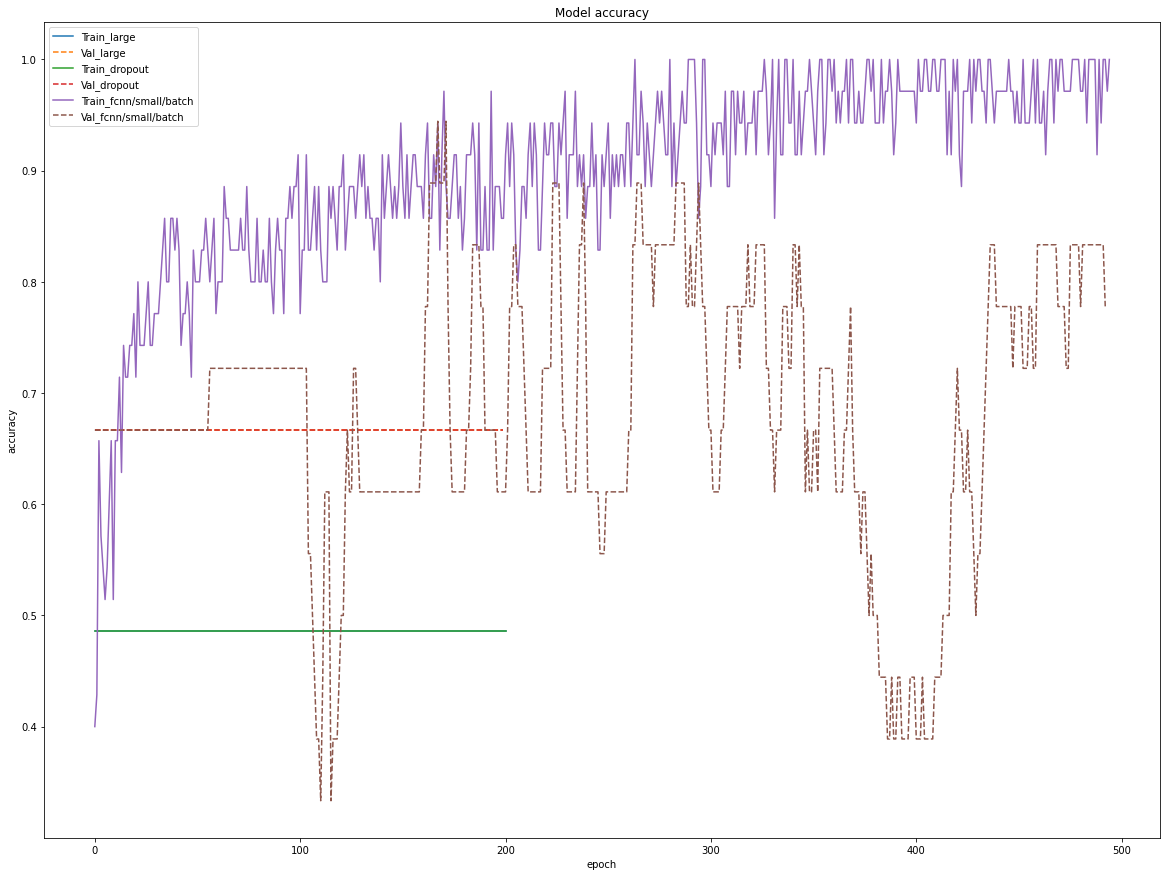

In [38]:
plot_report(batch_histories, 'accuracy')

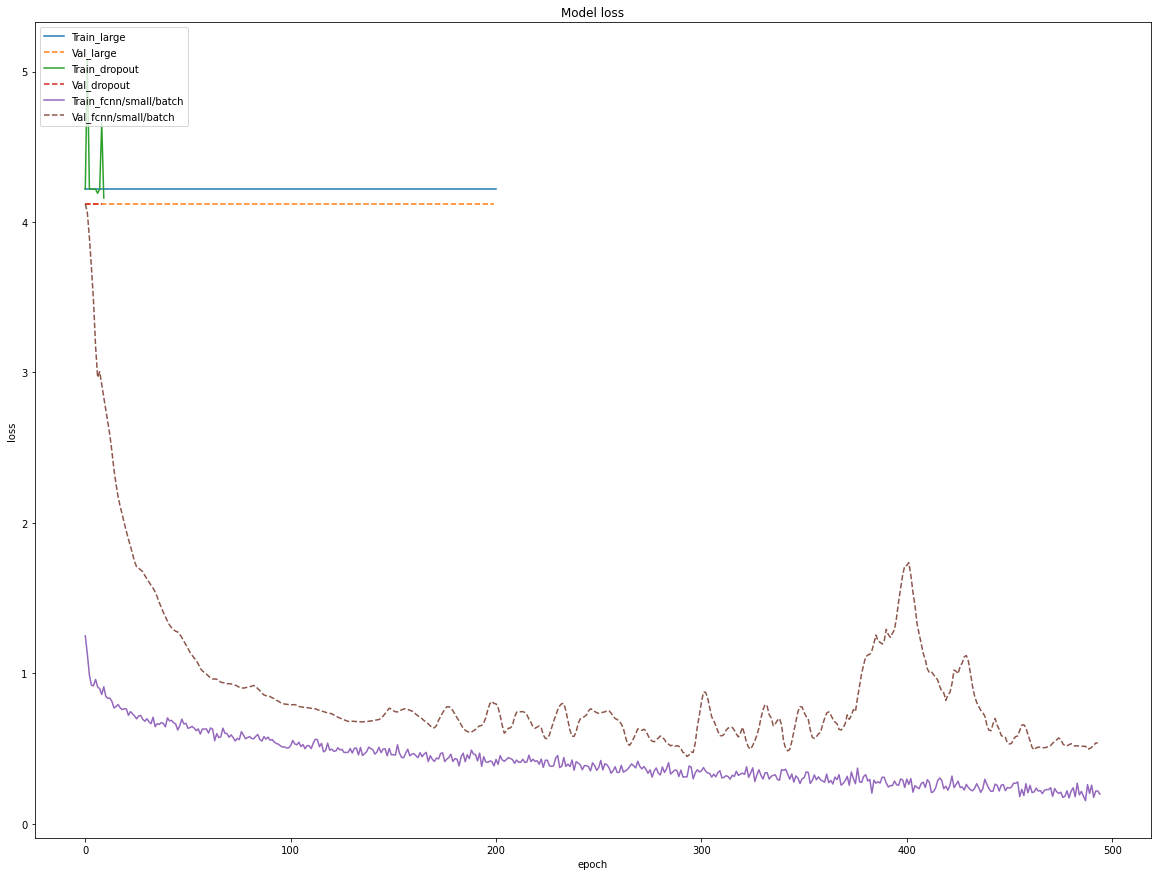

In [39]:
plot_report(batch_histories, 'loss')

## LSTM-FCNN

Univariate time series classification model, the Long Short Term Memory Fully Convolutional Network (LSTM-FCN) to capture time related information

In [40]:
X = np.array(df_rs.values.tolist())
X.shape

(53, 4096, 2)

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=38)
n_timesteps = X.shape[1]
n_features = X.shape[2]

In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

In [43]:
lstm_histories = {}
lstm_histories['large'] = size_histories['fcnn/large']
lstm_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [44]:
lstm_units=24
lstm_tiny_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                         input_shape=(n_timesteps, n_features),
                        kernel_regularizer=regularizers.l2(lr2)
                        ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
#     tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/tiny'] = compile_and_fit(lstm_tiny_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/tiny")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('test acc:', max(lstm_histories['lstm/tiny'].history["val_accuracy"]))
print('train acc:', max(lstm_histories['lstm/tiny'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24)                2592      
                                                                 
 batch_normalization (BatchN  (None, 24)               96        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 2,915
Trainable params: 2,867
Non-trainable params: 48
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 1.1321 - accuracy: 0.2286 - val_loss: 1.1598 - v

1/1 [==============================] - 0s 116ms/step - loss: 1.0421 - accuracy: 0.5143 - val_loss: 1.0858 - val_accuracy: 0.2778
Epoch 52/1000
1/1 [==============================] - 0s 115ms/step - loss: 1.0396 - accuracy: 0.5143 - val_loss: 1.0832 - val_accuracy: 0.2778
Epoch 53/1000
1/1 [==============================] - 0s 115ms/step - loss: 1.0355 - accuracy: 0.4571 - val_loss: 1.0819 - val_accuracy: 0.2778
Epoch 54/1000
1/1 [==============================] - 0s 115ms/step - loss: 1.0337 - accuracy: 0.5143 - val_loss: 1.0816 - val_accuracy: 0.2778
Epoch 55/1000
1/1 [==============================] - 0s 116ms/step - loss: 1.0319 - accuracy: 0.5143 - val_loss: 1.0801 - val_accuracy: 0.2778
Epoch 56/1000
1/1 [==============================] - 0s 117ms/step - loss: 1.0272 - accuracy: 0.5143 - val_loss: 1.0775 - val_accuracy: 0.2778
Epoch 57/1000
1/1 [==============================] - 0s 116ms/step - loss: 1.0255 - accuracy: 0.5143 - val_loss: 1.0754 - val_accuracy: 0.2778
Epoch 58/1000

1/1 [==============================] - 0s 117ms/step - loss: 0.9597 - accuracy: 0.6000 - val_loss: 0.9592 - val_accuracy: 0.6667
Epoch 109/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.9584 - accuracy: 0.6000 - val_loss: 0.9579 - val_accuracy: 0.6667
Epoch 110/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.9566 - accuracy: 0.6000 - val_loss: 0.9557 - val_accuracy: 0.6667
Epoch 111/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.9575 - accuracy: 0.5714 - val_loss: 0.9536 - val_accuracy: 0.6667
Epoch 112/1000
1/1 [==============================] - 0s 113ms/step - loss: 0.9581 - accuracy: 0.5714 - val_loss: 0.9514 - val_accuracy: 0.6667
Epoch 113/1000
1/1 [==============================] - 0s 113ms/step - loss: 0.9551 - accuracy: 0.5714 - val_loss: 0.9492 - val_accuracy: 0.6667
Epoch 114/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.9494 - accuracy: 0.6000 - val_loss: 0.9470 - val_accuracy: 0.6667
Epoch 1

Epoch 165/1000
1/1 [==============================] - 0s 117ms/step - loss: 0.8440 - accuracy: 0.6571 - val_loss: 0.8318 - val_accuracy: 0.7778
Epoch 166/1000
1/1 [==============================] - 0s 118ms/step - loss: 0.8412 - accuracy: 0.6571 - val_loss: 0.8328 - val_accuracy: 0.7778
Epoch 167/1000
1/1 [==============================] - 0s 117ms/step - loss: 0.8397 - accuracy: 0.6571 - val_loss: 0.8303 - val_accuracy: 0.8333
Epoch 168/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.8373 - accuracy: 0.6571 - val_loss: 0.8324 - val_accuracy: 0.7778
Epoch 169/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.8327 - accuracy: 0.6857 - val_loss: 0.8286 - val_accuracy: 0.7778
Epoch 170/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.8343 - accuracy: 0.6571 - val_loss: 0.8376 - val_accuracy: 0.7778
Epoch 171/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.8303 - accuracy: 0.6857 - val_loss: 0.8400 - val_accuracy:

Epoch 222/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.7045 - accuracy: 0.6857 - val_loss: 0.8556 - val_accuracy: 0.7222
Epoch 223/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.7029 - accuracy: 0.6857 - val_loss: 0.8497 - val_accuracy: 0.7222
Epoch 224/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.7031 - accuracy: 0.6857 - val_loss: 0.8563 - val_accuracy: 0.7222
Epoch 225/1000
1/1 [==============================] - 0s 113ms/step - loss: 0.6981 - accuracy: 0.6857 - val_loss: 0.8695 - val_accuracy: 0.7222
Epoch 226/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.7001 - accuracy: 0.6857 - val_loss: 0.8548 - val_accuracy: 0.7222
Epoch 227/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.6940 - accuracy: 0.6857 - val_loss: 0.8472 - val_accuracy: 0.7222
Epoch 228/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.6946 - accuracy: 0.6857 - val_loss: 0.8512 - val_accuracy:

Epoch 279/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.6122 - accuracy: 0.6857 - val_loss: 0.8401 - val_accuracy: 0.6667
Epoch 280/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.6182 - accuracy: 0.7143 - val_loss: 0.8039 - val_accuracy: 0.6667
Epoch 281/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.6131 - accuracy: 0.6857 - val_loss: 0.7874 - val_accuracy: 0.6667
Epoch 282/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.6182 - accuracy: 0.6571 - val_loss: 0.8004 - val_accuracy: 0.6667
Epoch 283/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.6109 - accuracy: 0.6857 - val_loss: 0.8339 - val_accuracy: 0.6667
Epoch 284/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.6060 - accuracy: 0.6857 - val_loss: 0.8381 - val_accuracy: 0.6667
Epoch 285/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.6072 - accuracy: 0.7143 - val_loss: 0.7990 - val_accuracy:

Epoch 336/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.5474 - accuracy: 0.7714 - val_loss: 0.9578 - val_accuracy: 0.3889
Epoch 337/1000
1/1 [==============================] - 0s 119ms/step - loss: 0.6271 - accuracy: 0.7143 - val_loss: 0.9597 - val_accuracy: 0.3889
Epoch 338/1000
1/1 [==============================] - 0s 117ms/step - loss: 0.6308 - accuracy: 0.7143 - val_loss: 0.9340 - val_accuracy: 0.3889
Epoch 339/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.5480 - accuracy: 0.8000 - val_loss: 0.8386 - val_accuracy: 0.3889
Epoch 340/1000
1/1 [==============================] - 0s 123ms/step - loss: 0.6054 - accuracy: 0.7429 - val_loss: 0.8450 - val_accuracy: 0.3889
Epoch 341/1000
1/1 [==============================] - 0s 119ms/step - loss: 0.6111 - accuracy: 0.7429 - val_loss: 0.8653 - val_accuracy: 0.3889
Epoch 342/1000
1/1 [==============================] - 0s 120ms/step - loss: 0.6100 - accuracy: 0.7429 - val_loss: 0.8681 - val_accuracy:

Epoch 393/1000
1/1 [==============================] - 0s 119ms/step - loss: 0.5247 - accuracy: 0.7429 - val_loss: 0.9285 - val_accuracy: 0.6667
Epoch 394/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.5106 - accuracy: 0.8000 - val_loss: 0.9247 - val_accuracy: 0.6667
Epoch 395/1000
1/1 [==============================] - 0s 118ms/step - loss: 0.5086 - accuracy: 0.8000 - val_loss: 0.8274 - val_accuracy: 0.6667
Epoch 396/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.5187 - accuracy: 0.7714 - val_loss: 0.8091 - val_accuracy: 0.6667
Epoch 397/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.5260 - accuracy: 0.7429 - val_loss: 1.8488 - val_accuracy: 0.3333
Epoch 398/1000
1/1 [==============================] - 0s 120ms/step - loss: 0.5565 - accuracy: 0.7143 - val_loss: 3.4303 - val_accuracy: 0.3333
Epoch 399/1000
1/1 [==============================] - 0s 121ms/step - loss: 0.5331 - accuracy: 0.7714 - val_loss: 3.2947 - val_accuracy:

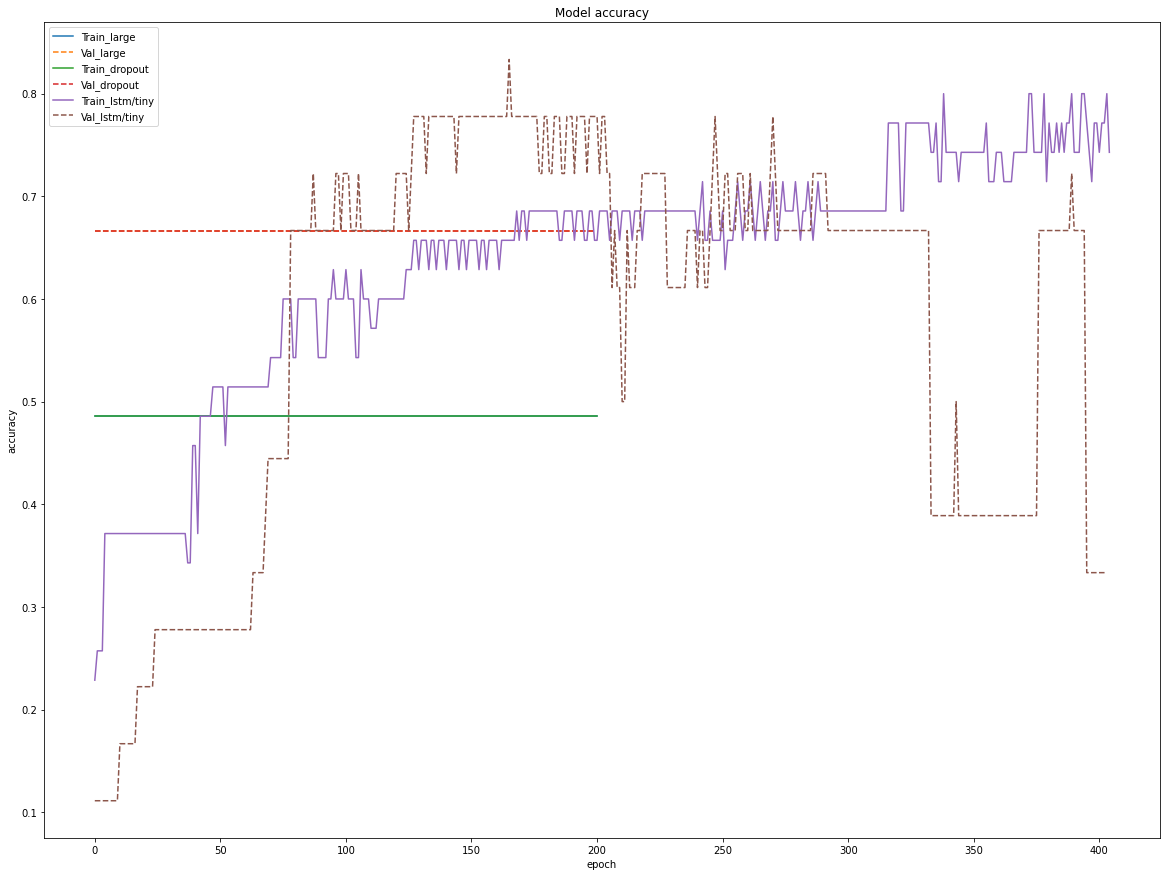

In [45]:
plot_report(lstm_histories, 'accuracy')

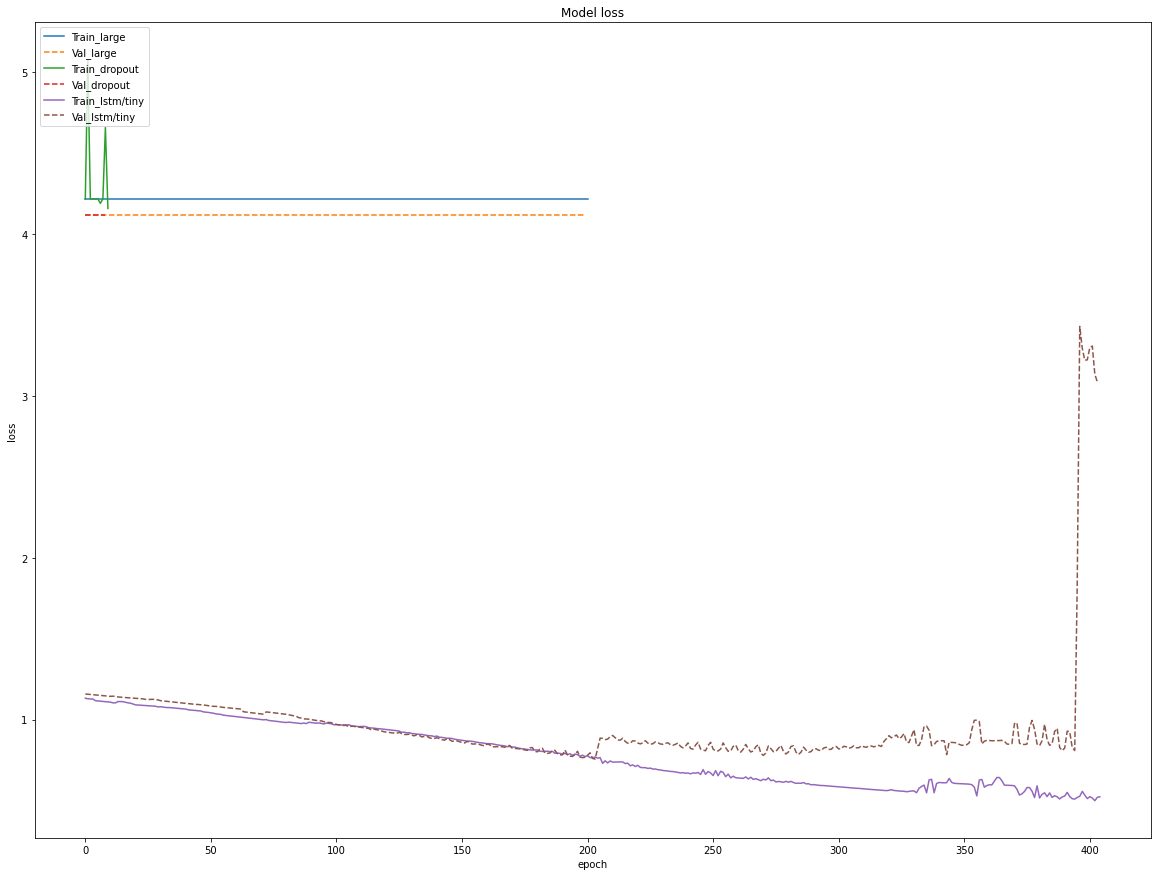

In [46]:
plot_report(lstm_histories, 'loss')

In [48]:
lstm_small_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                         input_shape=(n_timesteps, n_features),
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/small'] = compile_and_fit(lstm_small_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/small")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/small'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/small'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4096, 24)          2592      
                                                                 
 batch_normalization (BatchN  (None, 4096, 24)         96        
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 24)                4704      
                                                                 
 batch_normalization_1 (Batc  (None, 24)               96        
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 8)                 200       
                                                                 
 dropout (Dropout)           (None, 8)                 0

1/1 [==============================] - 0s 224ms/step - loss: 0.7117 - accuracy: 0.6000 - val_loss: 0.8584 - val_accuracy: 0.7778
Epoch 49/1000
1/1 [==============================] - 0s 228ms/step - loss: 0.7281 - accuracy: 0.6286 - val_loss: 0.8543 - val_accuracy: 0.7778
Epoch 50/1000
1/1 [==============================] - 0s 220ms/step - loss: 0.7289 - accuracy: 0.6000 - val_loss: 0.8506 - val_accuracy: 0.7778
Epoch 51/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.6503 - accuracy: 0.6571 - val_loss: 0.8468 - val_accuracy: 0.7778
Epoch 52/1000
1/1 [==============================] - 0s 224ms/step - loss: 0.6447 - accuracy: 0.6857 - val_loss: 0.8431 - val_accuracy: 0.7778
Epoch 53/1000
1/1 [==============================] - 0s 223ms/step - loss: 0.6642 - accuracy: 0.6857 - val_loss: 0.8395 - val_accuracy: 0.7778
Epoch 54/1000
1/1 [==============================] - 0s 224ms/step - loss: 0.6975 - accuracy: 0.7143 - val_loss: 0.8361 - val_accuracy: 0.8889
Epoch 55/1000

1/1 [==============================] - 0s 223ms/step - loss: 0.5625 - accuracy: 0.7143 - val_loss: 0.7756 - val_accuracy: 0.8889
Epoch 106/1000
1/1 [==============================] - 0s 225ms/step - loss: 0.6346 - accuracy: 0.6857 - val_loss: 0.7765 - val_accuracy: 0.8889
Epoch 107/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.5522 - accuracy: 0.7429 - val_loss: 0.7767 - val_accuracy: 0.8889
Epoch 108/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.5993 - accuracy: 0.7143 - val_loss: 0.7760 - val_accuracy: 0.8889
Epoch 109/1000
1/1 [==============================] - 0s 221ms/step - loss: 0.5940 - accuracy: 0.6857 - val_loss: 0.7744 - val_accuracy: 0.8889
Epoch 110/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.5927 - accuracy: 0.6571 - val_loss: 0.7729 - val_accuracy: 0.8889
Epoch 111/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.6672 - accuracy: 0.6000 - val_loss: 0.7724 - val_accuracy: 0.8889
Epoch 1

Epoch 162/1000
1/1 [==============================] - 0s 227ms/step - loss: 0.5736 - accuracy: 0.6857 - val_loss: 0.7813 - val_accuracy: 0.8333
Epoch 163/1000
1/1 [==============================] - 0s 236ms/step - loss: 0.5488 - accuracy: 0.7429 - val_loss: 0.7839 - val_accuracy: 0.8333
Epoch 164/1000
1/1 [==============================] - 0s 228ms/step - loss: 0.5475 - accuracy: 0.7429 - val_loss: 0.7831 - val_accuracy: 0.8333
Epoch 165/1000
1/1 [==============================] - 0s 222ms/step - loss: 0.5967 - accuracy: 0.7143 - val_loss: 0.7807 - val_accuracy: 0.8333
Epoch 166/1000
1/1 [==============================] - 0s 226ms/step - loss: 0.5250 - accuracy: 0.7714 - val_loss: 0.7767 - val_accuracy: 0.8333
Epoch 167/1000
1/1 [==============================] - 0s 224ms/step - loss: 0.5453 - accuracy: 0.7429 - val_loss: 0.7716 - val_accuracy: 0.8333
Epoch 168/1000
1/1 [==============================] - 0s 226ms/step - loss: 0.5604 - accuracy: 0.7429 - val_loss: 0.7667 - val_accuracy:

Epoch 219/1000
1/1 [==============================] - 0s 226ms/step - loss: 0.4916 - accuracy: 0.7429 - val_loss: 0.7566 - val_accuracy: 0.8333
Epoch 220/1000
1/1 [==============================] - 0s 224ms/step - loss: 0.5129 - accuracy: 0.6857 - val_loss: 0.7510 - val_accuracy: 0.8333
Epoch 221/1000
1/1 [==============================] - 0s 230ms/step - loss: 0.4954 - accuracy: 0.7429 - val_loss: 0.7321 - val_accuracy: 0.8889
Epoch 222/1000
1/1 [==============================] - 0s 226ms/step - loss: 0.5026 - accuracy: 0.7429 - val_loss: 0.7057 - val_accuracy: 0.8889
Epoch 223/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.5728 - accuracy: 0.7143 - val_loss: 0.6959 - val_accuracy: 0.8889
Epoch 224/1000
1/1 [==============================] - 0s 222ms/step - loss: 0.5480 - accuracy: 0.6571 - val_loss: 0.6891 - val_accuracy: 0.8889
Epoch 225/1000
1/1 [==============================] - 0s 225ms/step - loss: 0.5061 - accuracy: 0.7429 - val_loss: 0.6870 - val_accuracy:

Epoch 276/1000
1/1 [==============================] - 0s 224ms/step - loss: 0.5014 - accuracy: 0.8000 - val_loss: 0.7543 - val_accuracy: 0.8333
Epoch 277/1000
1/1 [==============================] - 0s 225ms/step - loss: 0.4403 - accuracy: 0.8286 - val_loss: 0.7485 - val_accuracy: 0.8333
Epoch 278/1000
1/1 [==============================] - 0s 225ms/step - loss: 0.4483 - accuracy: 0.7429 - val_loss: 0.7441 - val_accuracy: 0.8333
Epoch 279/1000
1/1 [==============================] - 0s 227ms/step - loss: 0.4396 - accuracy: 0.7714 - val_loss: 0.7403 - val_accuracy: 0.8333
Epoch 280/1000
1/1 [==============================] - 0s 223ms/step - loss: 0.4136 - accuracy: 0.6857 - val_loss: 0.7392 - val_accuracy: 0.8333
Epoch 281/1000
1/1 [==============================] - 0s 224ms/step - loss: 0.4788 - accuracy: 0.7143 - val_loss: 0.7381 - val_accuracy: 0.8333
Epoch 282/1000
1/1 [==============================] - 0s 225ms/step - loss: 0.5142 - accuracy: 0.7143 - val_loss: 0.7400 - val_accuracy:

Epoch 333/1000
1/1 [==============================] - 0s 220ms/step - loss: 0.4949 - accuracy: 0.7143 - val_loss: 0.7892 - val_accuracy: 0.8333
Epoch 334/1000
1/1 [==============================] - 0s 221ms/step - loss: 0.4492 - accuracy: 0.8000 - val_loss: 0.8027 - val_accuracy: 0.8333
Epoch 335/1000
1/1 [==============================] - 0s 221ms/step - loss: 0.4517 - accuracy: 0.8000 - val_loss: 0.8139 - val_accuracy: 0.8333
Epoch 336/1000
1/1 [==============================] - 0s 222ms/step - loss: 0.4281 - accuracy: 0.7429 - val_loss: 0.8240 - val_accuracy: 0.8333
Epoch 337/1000
1/1 [==============================] - 0s 218ms/step - loss: 0.3942 - accuracy: 0.7429 - val_loss: 0.8318 - val_accuracy: 0.8333
Epoch 338/1000
1/1 [==============================] - 0s 222ms/step - loss: 0.4050 - accuracy: 0.8286 - val_loss: 0.8368 - val_accuracy: 0.8333
Epoch 339/1000
1/1 [==============================] - 0s 219ms/step - loss: 0.4377 - accuracy: 0.7429 - val_loss: 0.8399 - val_accuracy:

Epoch 390/1000
1/1 [==============================] - 0s 222ms/step - loss: 0.4695 - accuracy: 0.7429 - val_loss: 0.9227 - val_accuracy: 0.7222
Epoch 391/1000
1/1 [==============================] - 0s 222ms/step - loss: 0.4706 - accuracy: 0.6571 - val_loss: 0.9299 - val_accuracy: 0.7222
Epoch 392/1000
1/1 [==============================] - 0s 221ms/step - loss: 0.8042 - accuracy: 0.7143 - val_loss: 1.0331 - val_accuracy: 0.6667
Epoch 393/1000
1/1 [==============================] - 0s 229ms/step - loss: 0.8472 - accuracy: 0.6857 - val_loss: 0.9913 - val_accuracy: 0.6667
Epoch 394/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.8114 - accuracy: 0.7429 - val_loss: 0.8852 - val_accuracy: 0.7222
Epoch 395/1000
1/1 [==============================] - 0s 223ms/step - loss: 0.7065 - accuracy: 0.7714 - val_loss: 0.8522 - val_accuracy: 0.8889
Epoch 396/1000
1/1 [==============================] - 0s 224ms/step - loss: 0.7703 - accuracy: 0.7429 - val_loss: 0.8182 - val_accuracy:

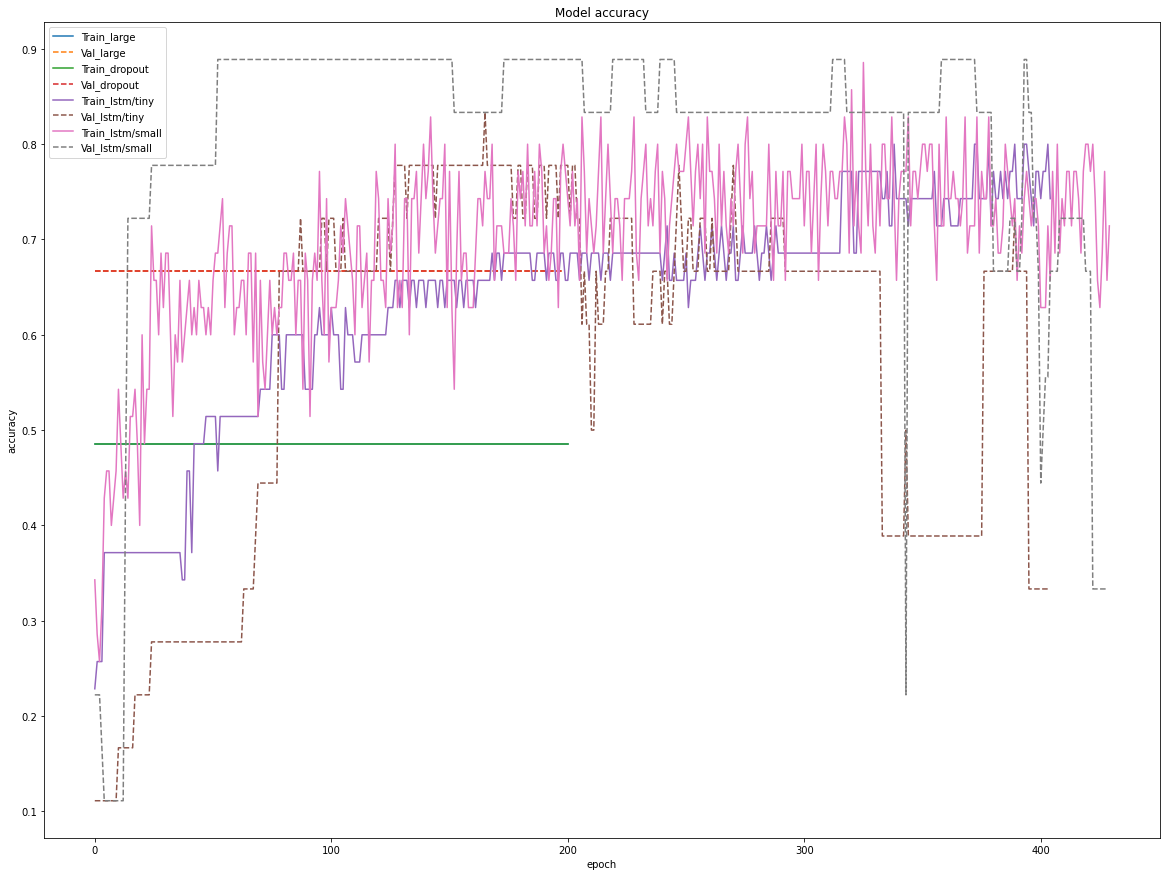

In [49]:
plot_report(lstm_histories, 'accuracy')

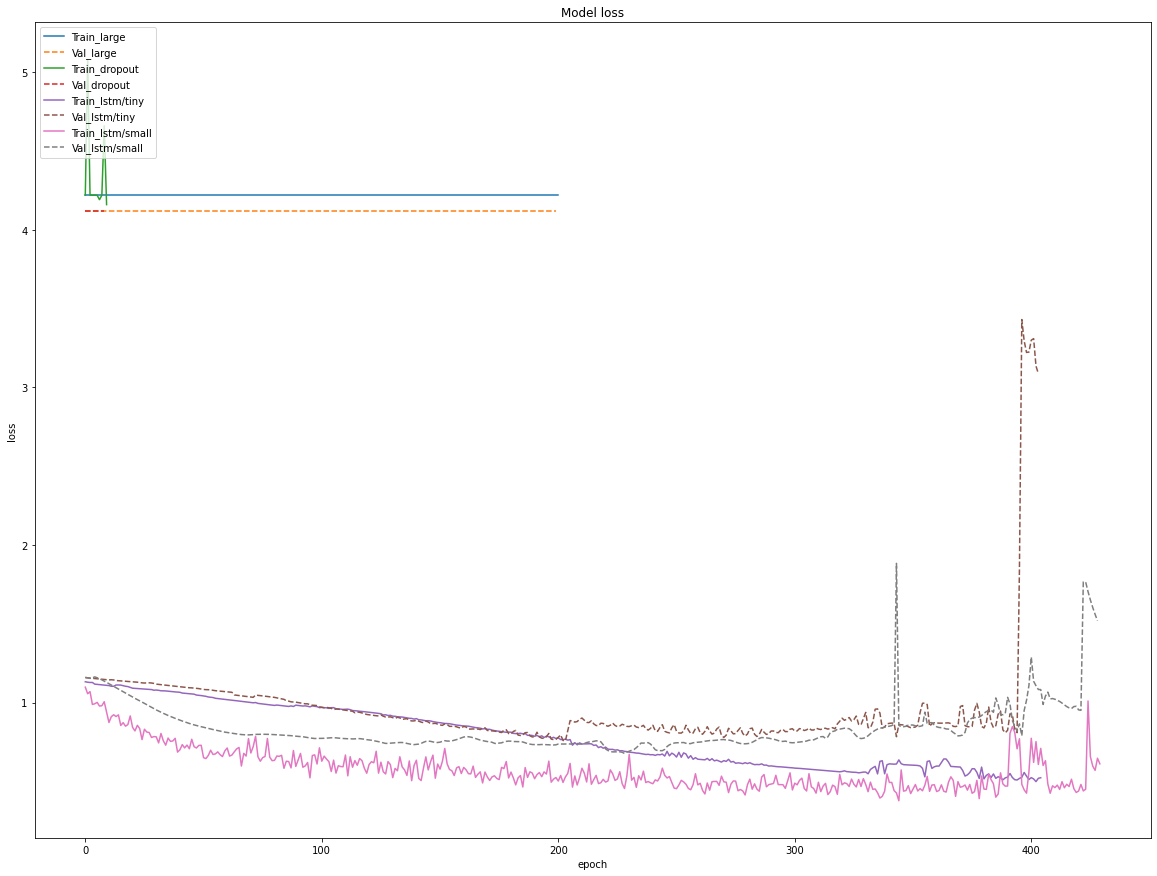

In [50]:
plot_report(lstm_histories, 'loss')

In [ ]:
lstm_units=64
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_large_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2), input_shape=(n_timesteps, n_features),),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/large'] = compile_and_fit(lstm_large_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                lr=1e-4,
#                                                multiplier=10), 
                                                name="lstm/large")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/large'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4096, 64)          17152     
                                                                 
 batch_normalization (BatchN  (None, 4096, 64)         256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               2

Epoch 40/1000
1/1 [==============================] - 0s 273ms/step - loss: 0.6554 - accuracy: 0.8571 - val_loss: 1.0606 - val_accuracy: 0.6667
Epoch 41/1000
1/1 [==============================] - 0s 265ms/step - loss: 0.6585 - accuracy: 0.8571 - val_loss: 1.0568 - val_accuracy: 0.6667
Epoch 42/1000
1/1 [==============================] - 0s 281ms/step - loss: 0.6789 - accuracy: 0.8286 - val_loss: 1.0527 - val_accuracy: 0.6667
Epoch 43/1000
1/1 [==============================] - 0s 269ms/step - loss: 0.6357 - accuracy: 0.8571 - val_loss: 1.0490 - val_accuracy: 0.6667
Epoch 44/1000
1/1 [==============================] - 0s 264ms/step - loss: 0.6422 - accuracy: 0.8286 - val_loss: 1.0452 - val_accuracy: 0.6667
Epoch 45/1000
1/1 [==============================] - 0s 276ms/step - loss: 0.6447 - accuracy: 0.8286 - val_loss: 1.0419 - val_accuracy: 0.6667
Epoch 46/1000
1/1 [==============================] - 0s 275ms/step - loss: 0.6753 - accuracy: 0.8000 - val_loss: 1.0387 - val_accuracy: 0.6667

1/1 [==============================] - 0s 262ms/step - loss: 0.5625 - accuracy: 0.8857 - val_loss: 0.9404 - val_accuracy: 0.6667
Epoch 98/1000
1/1 [==============================] - 0s 275ms/step - loss: 0.5564 - accuracy: 0.9429 - val_loss: 0.9436 - val_accuracy: 0.6667
Epoch 99/1000
1/1 [==============================] - 0s 276ms/step - loss: 0.5624 - accuracy: 0.8286 - val_loss: 0.9370 - val_accuracy: 0.6667
Epoch 100/1000
1/1 [==============================] - 0s 267ms/step - loss: 0.5682 - accuracy: 0.8857 - val_loss: 0.9359 - val_accuracy: 0.6667
Epoch 101/1000
1/1 [==============================] - 0s 272ms/step - loss: 0.5479 - accuracy: 0.8571 - val_loss: 0.9349 - val_accuracy: 0.6667
Epoch 102/1000
1/1 [==============================] - 0s 260ms/step - loss: 0.5678 - accuracy: 0.8857 - val_loss: 0.9337 - val_accuracy: 0.6667
Epoch 103/1000
1/1 [==============================] - 0s 275ms/step - loss: 0.5558 - accuracy: 0.8571 - val_loss: 0.9327 - val_accuracy: 0.6667
Epoch 104

1/1 [==============================] - 0s 278ms/step - loss: 0.4844 - accuracy: 0.9429 - val_loss: 0.8598 - val_accuracy: 0.7778
Epoch 155/1000
1/1 [==============================] - 0s 279ms/step - loss: 0.4725 - accuracy: 0.8857 - val_loss: 0.8587 - val_accuracy: 0.7778
Epoch 156/1000
1/1 [==============================] - 0s 279ms/step - loss: 0.5401 - accuracy: 0.8857 - val_loss: 0.8571 - val_accuracy: 0.7778
Epoch 157/1000
1/1 [==============================] - 0s 275ms/step - loss: 0.5077 - accuracy: 0.8571 - val_loss: 0.8540 - val_accuracy: 0.7778
Epoch 158/1000
1/1 [==============================] - 0s 276ms/step - loss: 0.4714 - accuracy: 0.8571 - val_loss: 0.8509 - val_accuracy: 0.7778
Epoch 159/1000
1/1 [==============================] - 0s 275ms/step - loss: 0.4587 - accuracy: 0.8857 - val_loss: 0.8488 - val_accuracy: 0.7778
Epoch 160/1000
1/1 [==============================] - 0s 277ms/step - loss: 0.5203 - accuracy: 0.8571 - val_loss: 0.8461 - val_accuracy: 0.7778
Epoch 1

Epoch 211/1000
1/1 [==============================] - 0s 258ms/step - loss: 0.4816 - accuracy: 0.9143 - val_loss: 0.7646 - val_accuracy: 0.7778
Epoch 212/1000
1/1 [==============================] - 0s 259ms/step - loss: 0.4693 - accuracy: 0.9143 - val_loss: 0.7591 - val_accuracy: 0.7778
Epoch 213/1000
1/1 [==============================] - 0s 255ms/step - loss: 0.4518 - accuracy: 0.9143 - val_loss: 0.7577 - val_accuracy: 0.7778
Epoch 214/1000
1/1 [==============================] - 0s 261ms/step - loss: 0.5074 - accuracy: 0.8857 - val_loss: 0.7610 - val_accuracy: 0.7778
Epoch 215/1000
1/1 [==============================] - 0s 255ms/step - loss: 0.4633 - accuracy: 0.8571 - val_loss: 0.7596 - val_accuracy: 0.7778
Epoch 216/1000
1/1 [==============================] - 0s 257ms/step - loss: 0.4636 - accuracy: 0.8571 - val_loss: 0.7591 - val_accuracy: 0.7778
Epoch 217/1000
1/1 [==============================] - 0s 258ms/step - loss: 0.4872 - accuracy: 0.8571 - val_loss: 0.7618 - val_accuracy:

Epoch 268/1000
1/1 [==============================] - 0s 254ms/step - loss: 0.4712 - accuracy: 0.8571 - val_loss: 0.7219 - val_accuracy: 0.7222
Epoch 269/1000
1/1 [==============================] - 0s 256ms/step - loss: 0.4691 - accuracy: 0.8286 - val_loss: 0.7236 - val_accuracy: 0.7222
Epoch 270/1000
1/1 [==============================] - 0s 256ms/step - loss: 0.5044 - accuracy: 0.8286 - val_loss: 0.7252 - val_accuracy: 0.7222
Epoch 271/1000
1/1 [==============================] - 0s 255ms/step - loss: 0.4614 - accuracy: 0.8571 - val_loss: 0.7186 - val_accuracy: 0.7222
Epoch 272/1000
1/1 [==============================] - 0s 252ms/step - loss: 0.4531 - accuracy: 0.8571 - val_loss: 0.7153 - val_accuracy: 0.7222
Epoch 273/1000
1/1 [==============================] - 0s 252ms/step - loss: 0.4040 - accuracy: 0.8857 - val_loss: 0.7172 - val_accuracy: 0.7222
Epoch 274/1000
1/1 [==============================] - 0s 252ms/step - loss: 0.4613 - accuracy: 0.8571 - val_loss: 0.7228 - val_accuracy:

Epoch 325/1000
1/1 [==============================] - 0s 256ms/step - loss: 0.5510 - accuracy: 0.7714 - val_loss: 0.7304 - val_accuracy: 0.8333
Epoch 326/1000
1/1 [==============================] - 0s 252ms/step - loss: 0.4324 - accuracy: 0.8571 - val_loss: 0.7327 - val_accuracy: 0.8333
Epoch 327/1000
1/1 [==============================] - 0s 251ms/step - loss: 0.3847 - accuracy: 0.8857 - val_loss: 0.7302 - val_accuracy: 0.8333
Epoch 328/1000
1/1 [==============================] - 0s 251ms/step - loss: 0.4532 - accuracy: 0.8286 - val_loss: 0.7221 - val_accuracy: 0.8333
Epoch 329/1000
1/1 [==============================] - 0s 261ms/step - loss: 0.4095 - accuracy: 0.8857 - val_loss: 0.7178 - val_accuracy: 0.8333
Epoch 330/1000
1/1 [==============================] - 0s 279ms/step - loss: 0.4512 - accuracy: 0.8857 - val_loss: 0.7216 - val_accuracy: 0.8333
Epoch 331/1000
1/1 [==============================] - 0s 278ms/step - loss: 0.4945 - accuracy: 0.8571 - val_loss: 0.7173 - val_accuracy:

Epoch 382/1000
1/1 [==============================] - 0s 256ms/step - loss: 0.5471 - accuracy: 0.8000 - val_loss: 0.7076 - val_accuracy: 0.7778
Epoch 383/1000
1/1 [==============================] - 0s 254ms/step - loss: 0.6880 - accuracy: 0.8000 - val_loss: 0.7199 - val_accuracy: 0.7778
Epoch 384/1000
1/1 [==============================] - 0s 258ms/step - loss: 0.5598 - accuracy: 0.7429 - val_loss: 0.6954 - val_accuracy: 0.7778
Epoch 385/1000
1/1 [==============================] - 0s 257ms/step - loss: 0.5075 - accuracy: 0.8286 - val_loss: 0.8065 - val_accuracy: 0.5000
Epoch 386/1000
1/1 [==============================] - 0s 259ms/step - loss: 0.5450 - accuracy: 0.7714 - val_loss: 0.7256 - val_accuracy: 0.7778
Epoch 387/1000
1/1 [==============================] - 0s 272ms/step - loss: 0.5171 - accuracy: 0.8000 - val_loss: 0.6297 - val_accuracy: 0.8333
Epoch 388/1000
1/1 [==============================] - 0s 256ms/step - loss: 0.5057 - accuracy: 0.8571 - val_loss: 0.5731 - val_accuracy:

Epoch 439/1000
1/1 [==============================] - 0s 256ms/step - loss: 0.4102 - accuracy: 0.8000 - val_loss: 1.3938 - val_accuracy: 0.6667
Epoch 440/1000
1/1 [==============================] - 0s 261ms/step - loss: 0.3972 - accuracy: 0.8000 - val_loss: 1.4390 - val_accuracy: 0.6667
Epoch 441/1000
1/1 [==============================] - 0s 253ms/step - loss: 0.3844 - accuracy: 0.8000 - val_loss: 1.4815 - val_accuracy: 0.6111
Epoch 442/1000
1/1 [==============================] - 0s 255ms/step - loss: 0.4416 - accuracy: 0.8000 - val_loss: 1.5514 - val_accuracy: 0.3333
Epoch 443/1000
1/1 [==============================] - 0s 265ms/step - loss: 0.3565 - accuracy: 0.8000 - val_loss: 1.6123 - val_accuracy: 0.3333
Epoch 444/1000
1/1 [==============================] - 0s 266ms/step - loss: 0.3955 - accuracy: 0.8000 - val_loss: 1.6517 - val_accuracy: 0.3333
Epoch 445/1000
1/1 [==============================] - 0s 252ms/step - loss: 0.4342 - accuracy: 0.8000 - val_loss: 1.2924 - val_accuracy:

Epoch 496/1000
1/1 [==============================] - 0s 265ms/step - loss: 0.3542 - accuracy: 0.8286 - val_loss: 0.5915 - val_accuracy: 0.7778
Epoch 497/1000
1/1 [==============================] - 0s 259ms/step - loss: 0.3404 - accuracy: 0.8000 - val_loss: 0.5946 - val_accuracy: 0.7778
Epoch 498/1000
1/1 [==============================] - 0s 262ms/step - loss: 0.3517 - accuracy: 0.8286 - val_loss: 0.6005 - val_accuracy: 0.7222
Epoch 499/1000
1/1 [==============================] - 0s 260ms/step - loss: 0.3446 - accuracy: 0.7714 - val_loss: 0.6088 - val_accuracy: 0.7222
Epoch 500/1000
1/1 [==============================] - 0s 258ms/step - loss: 0.3495 - accuracy: 0.8286 - val_loss: 0.6215 - val_accuracy: 0.7222
Epoch 501/1000
1/1 [==============================] - 0s 257ms/step - loss: 0.4018 - accuracy: 0.8571 - val_loss: 0.6357 - val_accuracy: 0.7222
Epoch 502/1000
1/1 [==============================] - 0s 257ms/step - loss: 0.4270 - accuracy: 0.9143 - val_loss: 0.6494 - val_accuracy:

Epoch 553/1000
1/1 [==============================] - 0s 268ms/step - loss: 0.3614 - accuracy: 0.8286 - val_loss: 0.6414 - val_accuracy: 0.7222
Epoch 554/1000
1/1 [==============================] - 0s 270ms/step - loss: 0.3350 - accuracy: 0.9143 - val_loss: 0.6321 - val_accuracy: 0.7222
Epoch 555/1000
1/1 [==============================] - 0s 263ms/step - loss: 0.3819 - accuracy: 0.8571 - val_loss: 0.6269 - val_accuracy: 0.7222
Epoch 556/1000
1/1 [==============================] - 0s 256ms/step - loss: 0.3207 - accuracy: 0.8857 - val_loss: 0.6200 - val_accuracy: 0.7222
Epoch 557/1000
1/1 [==============================] - 0s 257ms/step - loss: 0.3257 - accuracy: 0.8857 - val_loss: 0.6084 - val_accuracy: 0.7222
Epoch 558/1000
1/1 [==============================] - 0s 257ms/step - loss: 0.3569 - accuracy: 0.9143 - val_loss: 0.5955 - val_accuracy: 0.7222
Epoch 559/1000
1/1 [==============================] - 0s 260ms/step - loss: 0.3644 - accuracy: 0.8571 - val_loss: 0.5861 - val_accuracy:

In [ ]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'accuracy')

In [ ]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'loss')